# Transformer - Top model according to the SCPM of -3.25

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Time
import time

# Random and os for reproducibility
import random
import os

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
import tensorflow as tf

# Processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Making keras compatible with scikit learn api
# https://scikit-learn.org/stable/developers/develop.html
from sklearn.base import BaseEstimator, RegressorMixin

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Converting Times Series Data to 3D format
from src.utils.split_sequences import split_sequences

# Transformer Encoder for time series data
from src.models.transformer_ts_tf import Transformer

# To run cross validation parallelized
from joblib import Parallel, delayed

import joblib

import matplotlib

2024-12-01 17:40:08.446467: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 17:40:08.449124: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 17:40:08.498184: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 17:40:08.499236: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 17:40:09.306108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def generate_sequences_helper(
    dataset, cement_types, dates=None, timesteps=None, split_by_cement_type=False
):
    index_train = dataset["y_train"].index
    index_test = dataset["y_test"].index

    dataset["y_train"] = dataset["y_train"].reset_index(drop=True)
    dataset["y_test"] = dataset["y_test"].reset_index(drop=True)

    if dates is not None:
        dataset["dates_train"] = dates[index_train].reset_index(drop=True)
        dataset["dates_test"] = dates[index_test].reset_index(drop=True)

    dataset["cement_types_train"] = cement_types.loc[index_train].reset_index(drop=True)
    dataset["cement_types_test"] = cement_types.loc[index_test].reset_index(drop=True)

    dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

    return dataset

<IPython.core.display.Javascript object>

In [4]:
def generate_sequences(dataset, timesteps, split_by_cement_type=False):
    if split_by_cement_type:
        dataset["x_train"], dataset["y_train"] = split_sequences_per_cement_type(
            pd.concat(
                [
                    dataset["dates_train"],
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["cement_types_train"],
                    dataset["y_train"],
                ],
                axis=1,
            ),
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences_per_cement_type(
            pd.concat(
                [
                    dataset["dates_test"],
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["cement_types_test"],
                    dataset["y_test"],
                ],
                axis=1,
            ),
            timesteps,
        )
    else:
        dataset["x_train"], dataset["y_train"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["y_train"],
                ],
                axis=1,
            ).values,
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["y_test"],
                ],
                axis=1,
            ).values,
            timesteps,
        )
    return dataset

<IPython.core.display.Javascript object>

In [5]:
def impute_data(dataset, imputer=None, imputer_params=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply imputation to the data
    if imputer is not None:
        imputer = imputer() if imputer_params is None else imputer(**imputer_params)
        x_train = imputer.fit_transform(x_train)
        x_test = imputer.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return imputer, dataset

<IPython.core.display.Javascript object>

In [6]:
def transform_data(dataset, transformer=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply data normalization/standardization to the data
    if transformer is not None:
        scaler = transformer()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return scaler, dataset

<IPython.core.display.Javascript object>

In [7]:
def preprocess_data(dataset, transformer=None, imputer=None, imputer_params=None):
    imputer, dataset = impute_data(dataset, imputer, imputer_params)
    scaler, dataset = transform_data(dataset, transformer)
    return imputer, scaler, dataset

<IPython.core.display.Javascript object>

In [8]:
def train_and_evaluate_model(Estimator, dataset, estimator_params=None):
    """
    Purpose: Helper function to be used in conjunction with
    blocked time_series cross validation function
    """
    x_train = dataset["x_train"]
    y_train = dataset["y_train"]
    x_test = dataset["x_test"]
    y_test = dataset["y_test"]

    # Instantiate the model
    model = Estimator() if estimator_params is None else Estimator(**estimator_params)

    # Fitting the model
    model.fit(x_train, y_train)

    # Making predictions on train/test sets
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Return regression metrics
    return model, score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

<IPython.core.display.Javascript object>

In [9]:
def custom_cross_validate_parallelized(
    Estimator,
    Imputer,
    Transform,
    x,
    y,
    cv,
    timesteps,
    dates=None,
    cement_types=None,
    estimator_params=None,
    imputer_params=None,
    split_by_cement_type=True,
    n_jobs=-1,
    REPEAT=0,  # Add REPEAT as a parameter
):
    def process_fold(
        train_index, test_index, dates, cement_types, x, y, repeat_num, fold_num
    ):
        dataset = {
            "dates_train": dates[train_index].reset_index(drop=True),
            "cement_types_train": cement_types.loc[train_index].reset_index(drop=True),
            "x_train": x.loc[train_index].reset_index(drop=True),
            "y_train": y[train_index].reset_index(drop=True),
            "dates_test": dates[test_index].reset_index(drop=True),
            "cement_types_test": cement_types.loc[test_index].reset_index(drop=True),
            "x_test": x.loc[test_index].reset_index(drop=True),
            "y_test": y[test_index].reset_index(drop=True),
        }

        set_seeds(SEED + repeat_num)

        # Preprocess the dataset
        imputer, scaler, dataset = preprocess_data(
            dataset, Transform, Imputer, imputer_params
        )

        # Generate sequences (3D format)
        dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

        # Train and Evaluate the model
        estimator, score = train_and_evaluate_model(
            Estimator, dataset, estimator_params
        )

        # Create a directory to save models if it doesn't exist
        model_dir = f"models_repeat{repeat_num}_fold{fold_num}"
        os.makedirs(model_dir, exist_ok=True)

        # Save the imputer
        imputer_filename = os.path.join(model_dir, f"imputer.joblib")
        joblib.dump(imputer, imputer_filename)

        # Save the scaler
        scaler_filename = os.path.join(model_dir, f"scaler.joblib")
        joblib.dump(scaler, scaler_filename)

        # Save the Keras model
        # model_filename = os.path.join(model_dir, f"keras_model.h5")
        # estimator.model.save(model_filename)
        # Save the Keras model in SavedModel format
        model_filename = os.path.join(model_dir, f"keras_model")  # No extension
        estimator.model.save(model_filename, save_format="tf")  # Specify save_format

        # Optionally, return the filenames
        filenames = {
            "imputer": imputer_filename,
            "scaler": scaler_filename,
            "model": model_filename,
        }

        return score, filenames

    # Use enumerate to get fold numbers
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_fold)(
            train_index, test_index, dates, cement_types, x, y, REPEAT, fold_num
        )
        for fold_num, (train_index, test_index) in enumerate(cv.split(x))
    )

    # Unpack scores and filenames
    scores, filenames_list = zip(*results)

    # Process scores as before
    scores_final = {key: [] for key, _ in scores[0].items()}
    for scores_dict in scores:
        for key, value in scores_dict.items():
            scores_final[key] += [value]

    # Optionally, collect filenames
    # filenames_list contains the filenames for each fold

    results = [scores_final]
    return filenames_list, results

<IPython.core.display.Javascript object>

In [10]:
class TransformerWrapper(RegressorMixin):
    def __init__(self, params):
        self.params = params
        self.model = self.get_model()
        self.batch_size = self.params.get("batch_size", 16)
        self.epochs = self.params.get("epochs", 300)
        self.verbose = self.params.get("verbose", 0)
        self.callbacks = self.params.get("callbacks", None)
        self.validation_split = self.params.get("validation_split", 0.0)
        self.num_features = self.params.get("num_features", x.shape[-1])

    def fit(self, X=None, y=None):
        self.model.build(X.shape)
        self.load_pretrained_weights()
        self.history = self.model.fit(
            X,
            y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            validation_split=self.validation_split,
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = Transformer(
            num_hid=self.params["num_features"],
            time_steps=self.params["timesteps"],
            num_head=self.params["num_heads"],
            num_layers_enc=self.params["num_layers_enc"],
            num_feed_forward=self.params["num_feed_forward"],
            dropout_rate=self.params.get("dropout_rate", 0.1),
            activation=self.params.get("activation", "relu"),
        )
        model.compile(
            tf.keras.optimizers.Adam(learning_rate=0.001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

    def load_pretrained_weights(self, freeze_layers=0):
        # Load global weights
        self.model.load_weights(full_path)

        # Freeze layers
        for layer in self.model.layers[:freeze_layers]:
            layer.trainable = False
        if freeze_layers > 0:
            self.model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                loss="mse",
                metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
            )
        return

    def save(self, filepath):
        self.model.save(filepath)

<IPython.core.display.Javascript object>

In [11]:
def pad_time_series(dataframe, timesteps):
    """
    Pad timeseries with zeros
    """
    df_tmp = pd.DataFrame(
        dict(
            zip(
                dataframe.columns,
                [[0 for _ in range(timesteps - 1)] for _ in range(dataframe.shape[1])],
            )
        )
    )
    df_tmp[DATE] = dataframe[DATE].iloc[0]
    return pd.concat([df_tmp, dataframe], axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [12]:
def split_sequences_per_cement_type(dataframe, timesteps, pad=False):
    """
    Create sequences per cement time
    to avoid having parts of the sequence
    of different types of cement.
    """
    if timesteps == 1:
        return split_sequences(
            dataframe.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps
        )

    dates = dataframe[DATE][timesteps - 1 :]
    data = []
    dataframes = []

    for cement_type in CEMENT_TYPES:
        data.append(dataframe[dataframe[cement_type] == 1])
    data.append(dataframe[(dataframe[CEMENT_TYPES] == 0).all(axis=1)])

    for df in data:
        if pad:
            dates = df[DATE].reset_index(drop=True)
            df = pad_time_series(df, timesteps).reset_index(drop=True)
        else:
            dates = df[DATE][timesteps - 1 :].reset_index(drop=True)
        x, y = split_sequences(df.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps)
        x = pd.DataFrame({"Sequences": [sample.tolist() for sample in x]})
        y = pd.DataFrame({"Target": y})
        dataframes.append(pd.concat([dates, x, y], axis=1))

    data = pd.concat(dataframes, axis=0)
    data[DATE] = pd.to_datetime(data[DATE])
    data = data.sort_values(by=DATE).reset_index(drop=True)
    x = data["Sequences"]
    y = data["Target"].values
    x = np.array(x.tolist())

    return x, y

<IPython.core.display.Javascript object>

In [13]:
SEED = 47
REPEAT = 0

<IPython.core.display.Javascript object>

In [14]:
def set_seeds(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


# https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed

<IPython.core.display.Javascript object>

In [15]:
def set_global_determinism():
    set_seeds(seed=SEED)

    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

<IPython.core.display.Javascript object>

In [16]:
def get_transformer_params(
    timesteps=1,
    num_features=0,
    num_heads=1,
    num_layers_enc=1,
    num_feed_forward=16,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=None,
    validation_split=0.0,
    verbose=0,
):
    params = {}
    params["num_features"] = num_features
    params["timesteps"] = timesteps
    params["num_heads"] = num_heads
    params["num_layers_enc"] = num_layers_enc
    params["num_feed_forward"] = num_feed_forward
    params["verbose"] = verbose
    params["dropout_rate"] = dropout_rate
    params["activation"] = activation
    params["batch_size"] = batch_size
    params["epochs"] = epochs
    params["callbacks"] = callbacks
    params["validation_split"] = validation_split

    return params

<IPython.core.display.Javascript object>

In [17]:
weights_path = "../../../../models/global_models/209/transformer/s/pre_training/"
model_name = "transformer_chemical_vars_weights.h5"
full_path = os.path.join(weights_path, model_name)

<IPython.core.display.Javascript object>

In [18]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}
DATE = "Date"
CEMENT_TYPES = ["Cement_Type_CP II-Z-32"]

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [19]:
results_to_save = []

results_dict = {
    "Category": "Global Model",
    "Company": "209",
    "Plant": "S",
    "Features": "Chemical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Transformer",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [20]:
df = pd.read_csv("../../../../data/processed/209/s.csv")

<IPython.core.display.Javascript object>

## Defining Features

In [21]:
df_copy = df.copy()
df_copy = pd.get_dummies(data=df_copy, columns=["Cement_Type"], drop_first=True)

df_copy = df_copy.drop(
    [
        "Blaine",
        "#400",
        "Final setting time",
        "Initial setting time",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [22]:
df_copy[CEMENT_TYPES] = df_copy[CEMENT_TYPES].astype(int)
dates = df["Date"].copy()
y = df_copy.pop("CS28")
x = df_copy
df_copy = pd.concat([x, y], axis=1)

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


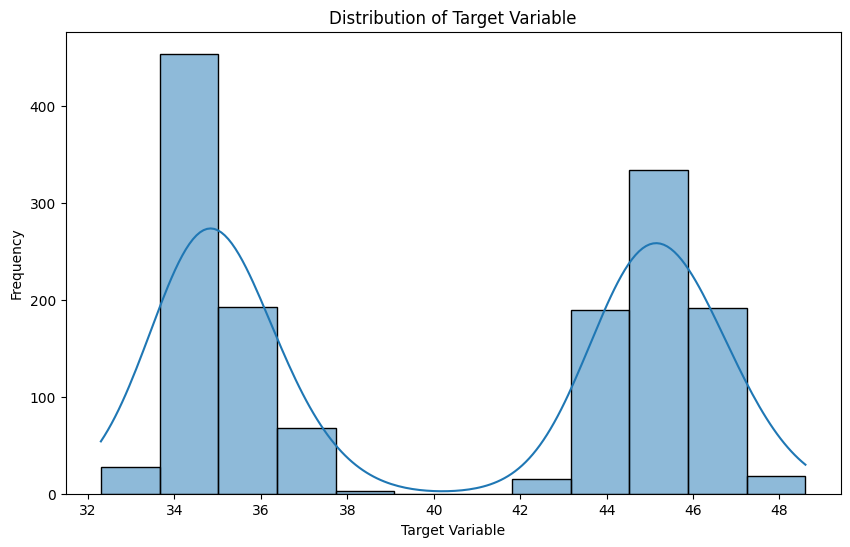

<IPython.core.display.Javascript object>

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title('Distribution of Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.show()


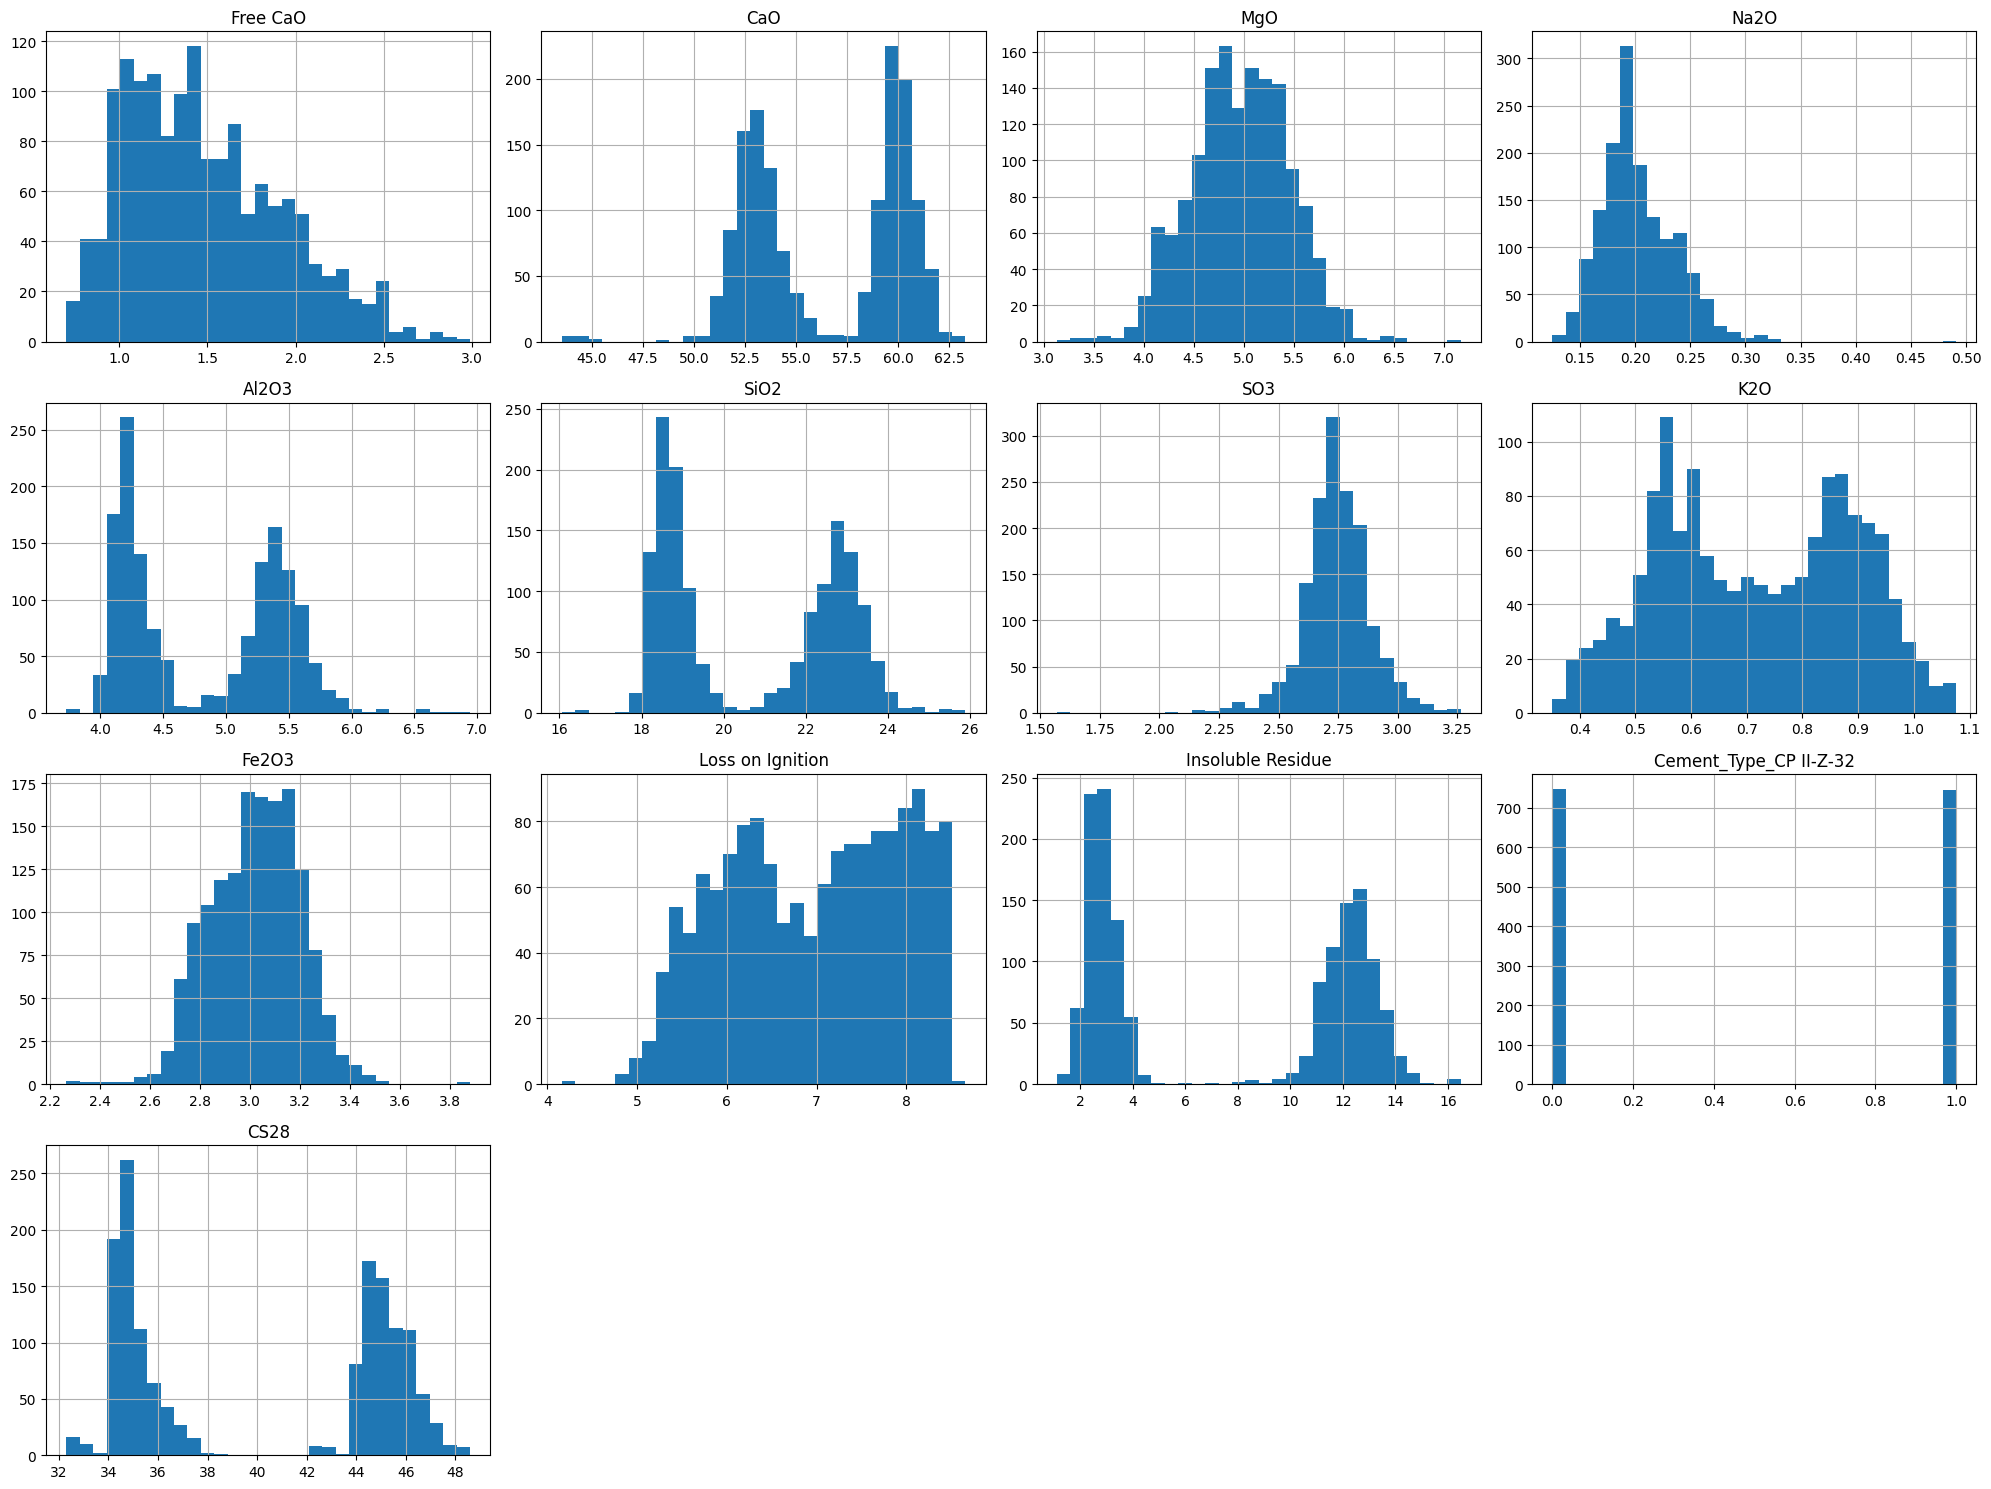

<IPython.core.display.Javascript object>

In [24]:
df_copy.hist(bins=30, figsize=(20, 15))
plt.tight_layout()
plt.show()

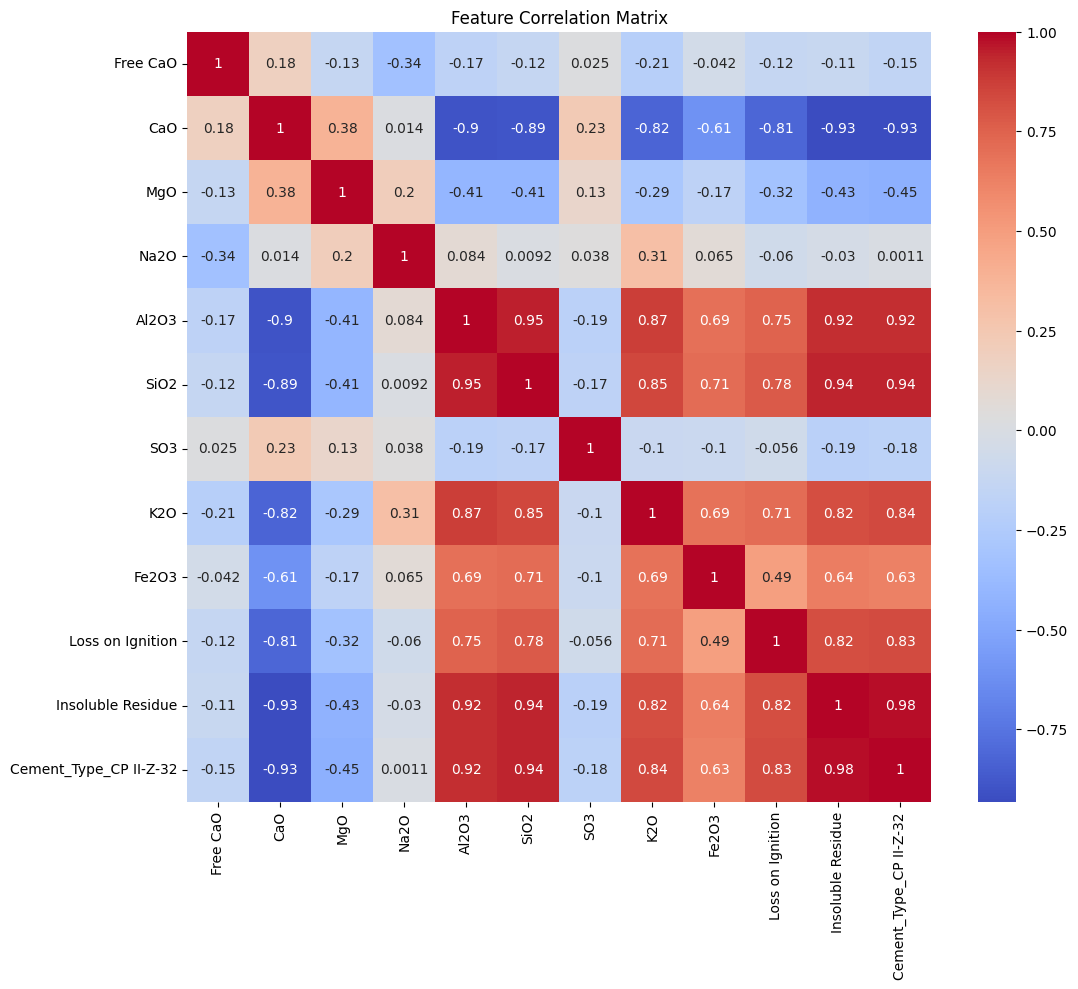

<IPython.core.display.Javascript object>

In [25]:
corr_matrix = x.drop("Date", axis=1).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


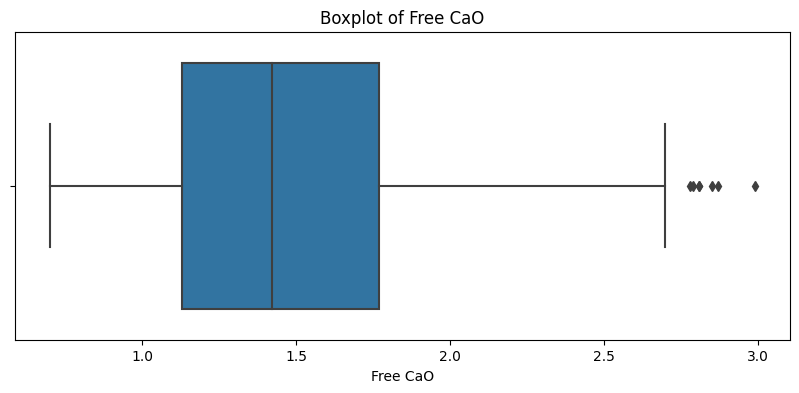

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


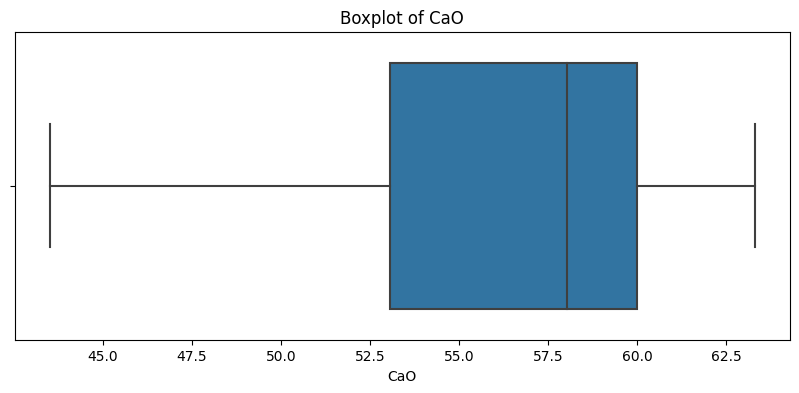

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


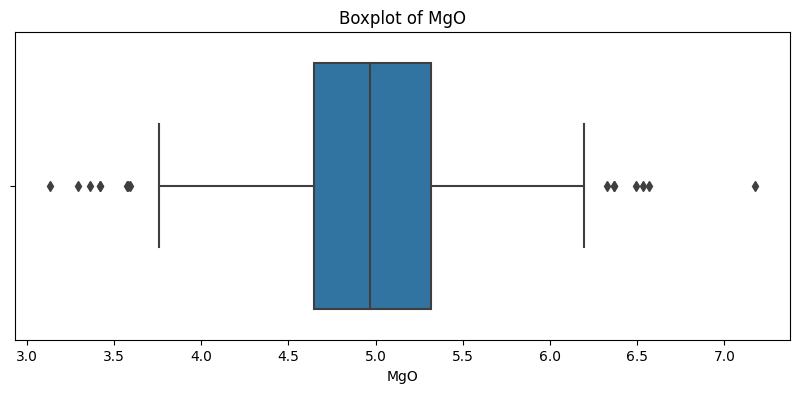

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


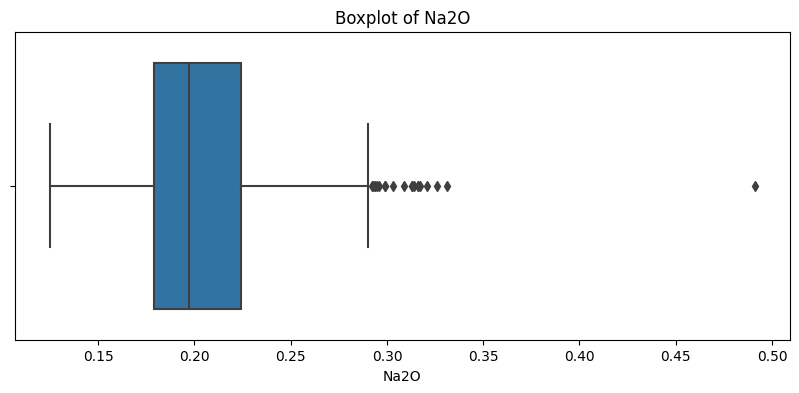

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


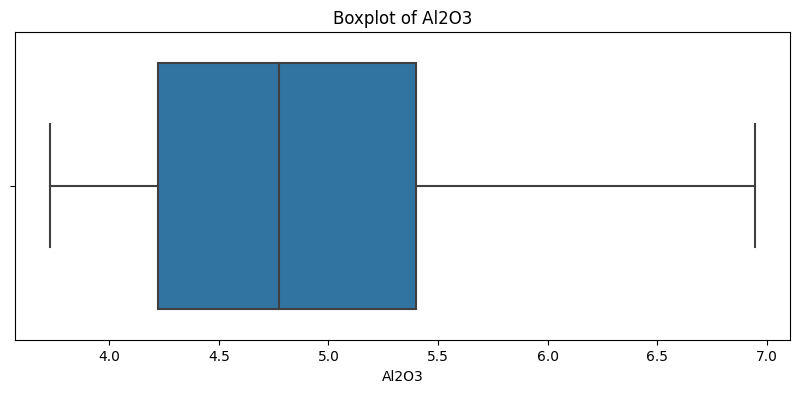

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


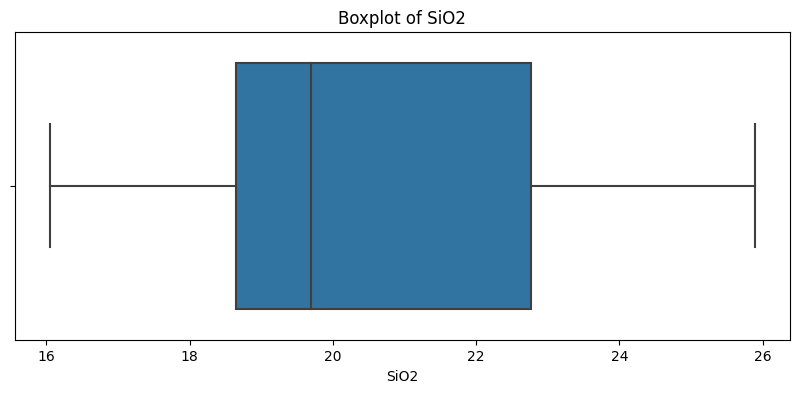

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


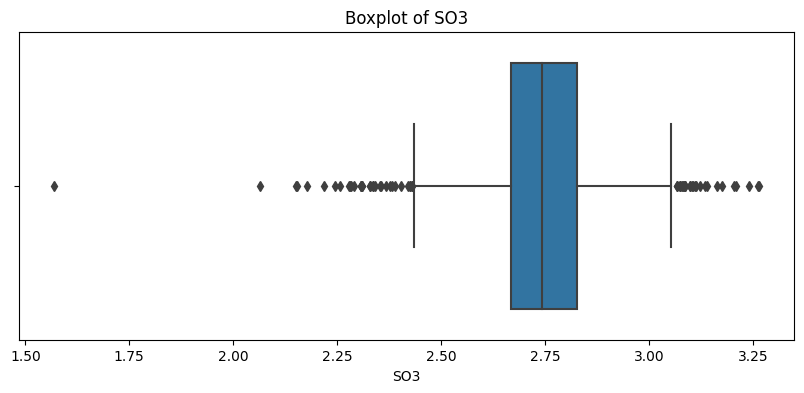

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


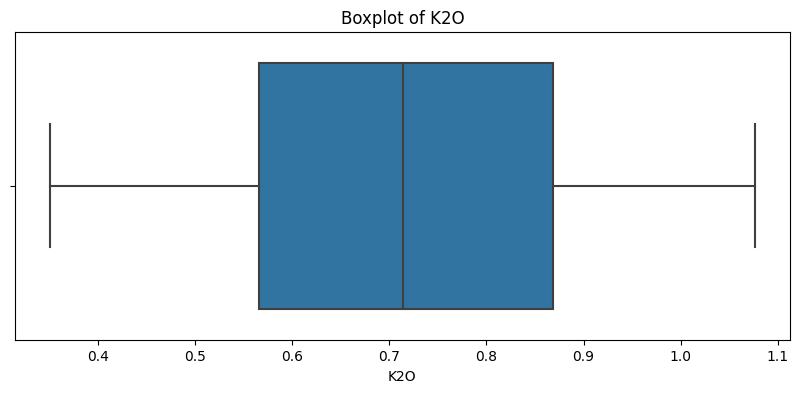

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


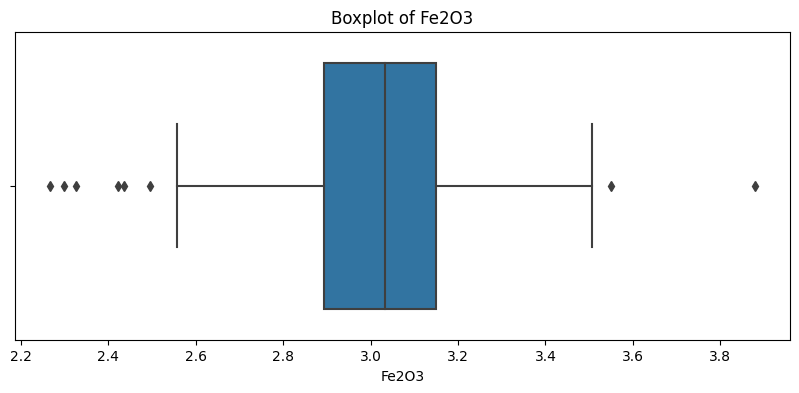

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


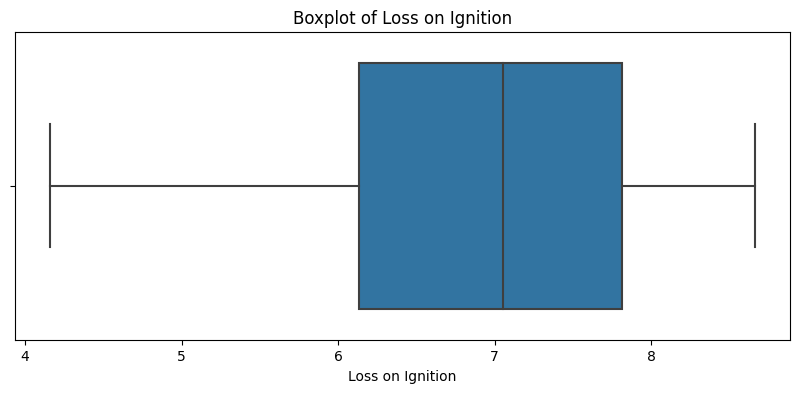

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


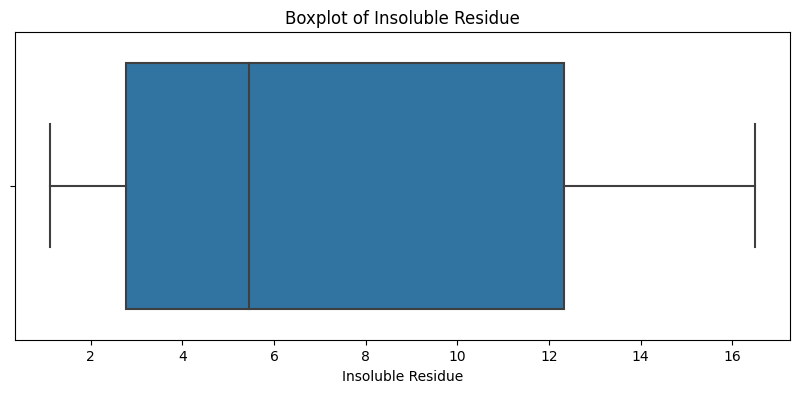

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


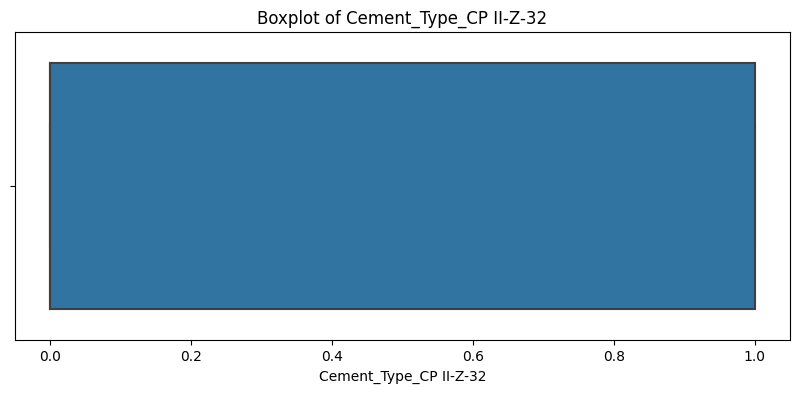

<IPython.core.display.Javascript object>

In [26]:

for column in x.drop("Date", axis=1).columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=x[column])
    plt.title(f'Boxplot of {column}')
    plt.show()


In [27]:
missing_values = df_copy.isnull().sum()
print(missing_values[missing_values > 0])


Free CaO             4
CaO                  6
MgO                  6
Na2O                 6
Al2O3                9
SiO2                 6
SO3                  6
K2O                  6
Fe2O3                6
Loss on Ignition     3
Insoluble Residue    5
dtype: int64


<IPython.core.display.Javascript object>

In [28]:
print(df_copy.dtypes)


Date                       object
Free CaO                  float64
CaO                       float64
MgO                       float64
Na2O                      float64
Al2O3                     float64
SiO2                      float64
SO3                       float64
K2O                       float64
Fe2O3                     float64
Loss on Ignition          float64
Insoluble Residue         float64
Cement_Type_CP II-Z-32      int64
CS28                      float64
dtype: object


<IPython.core.display.Javascript object>

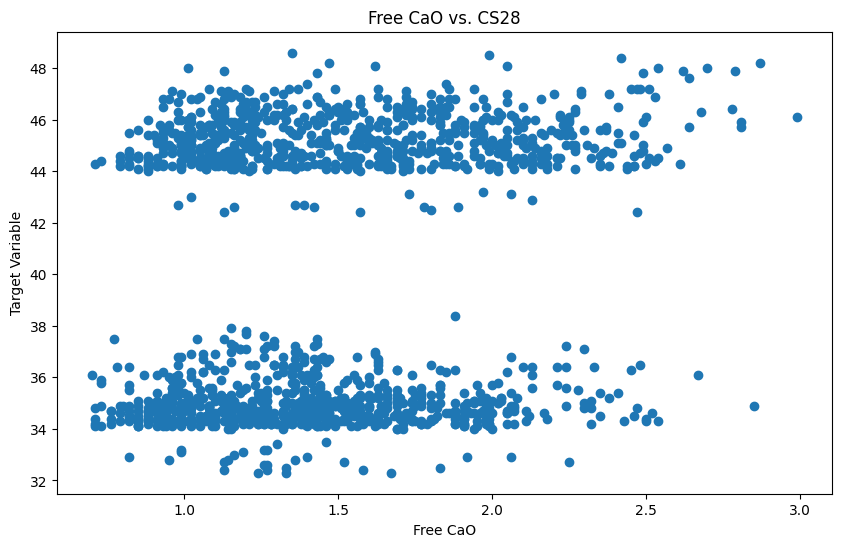

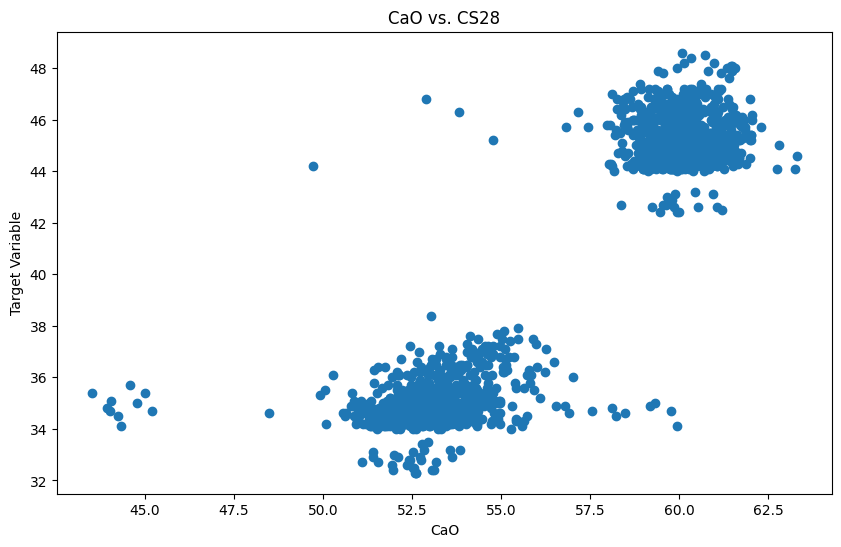

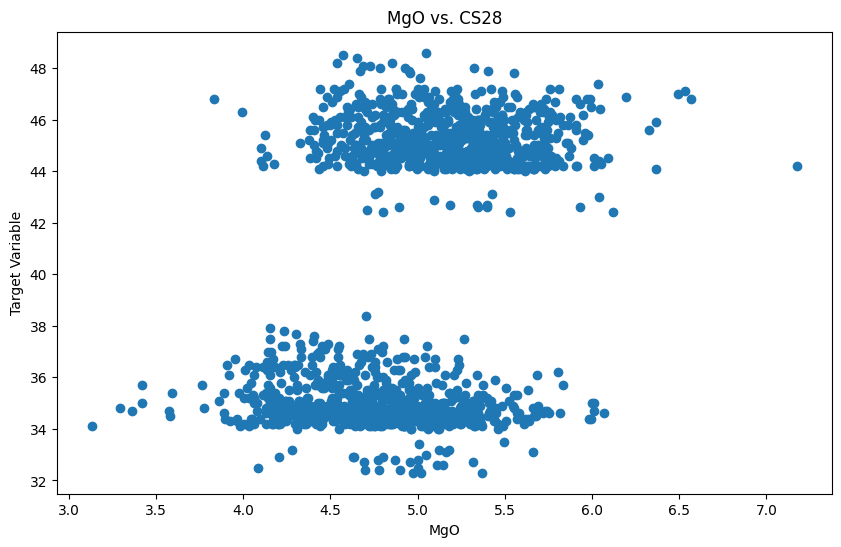

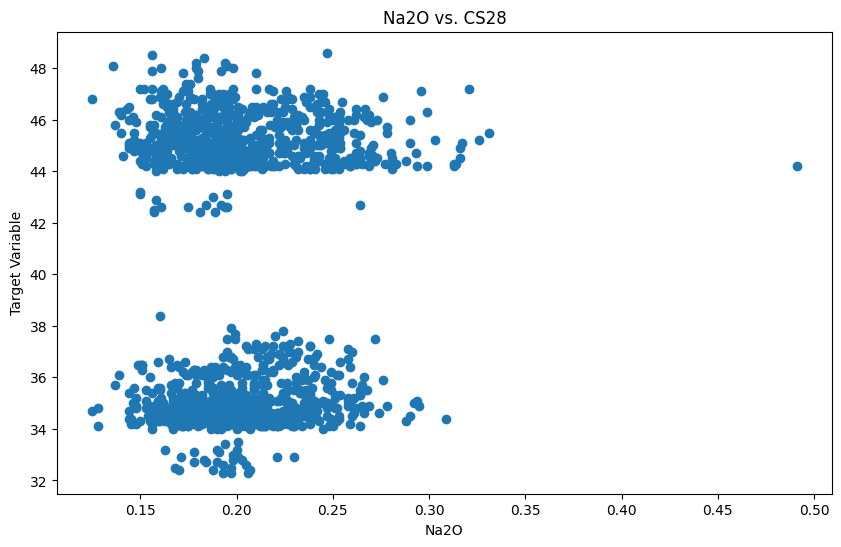

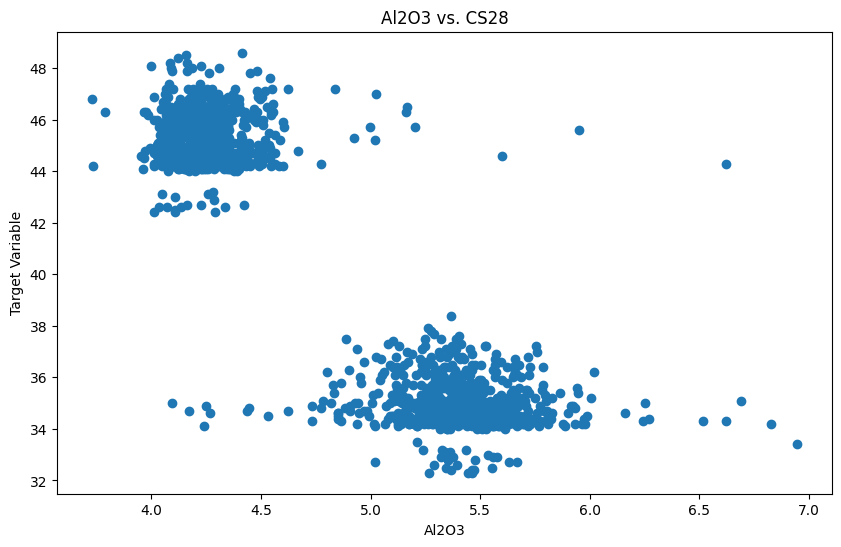

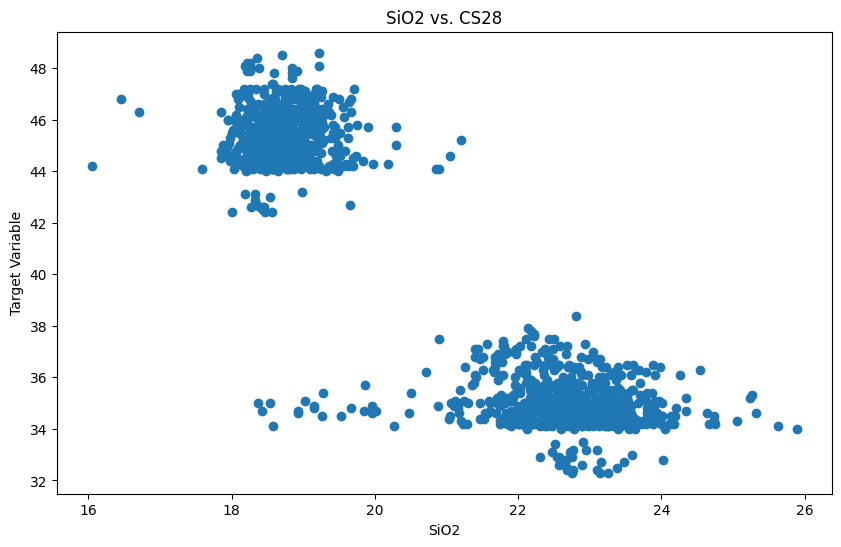

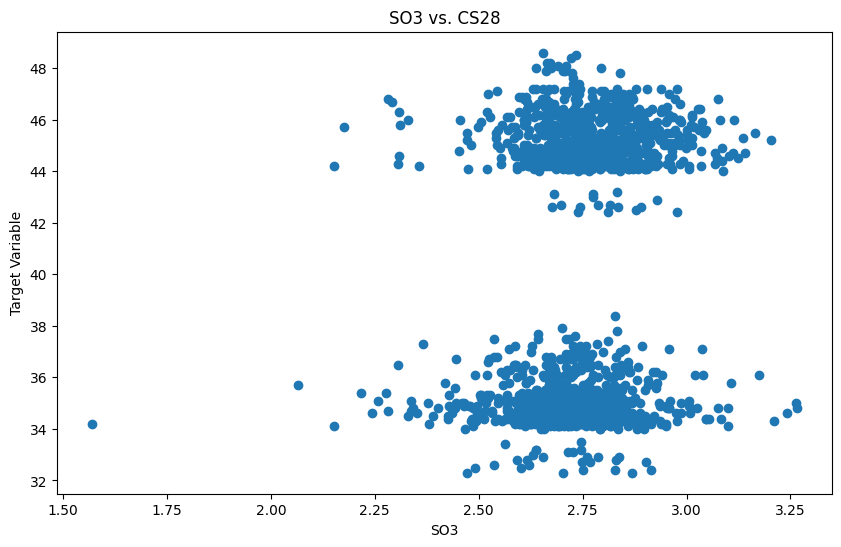

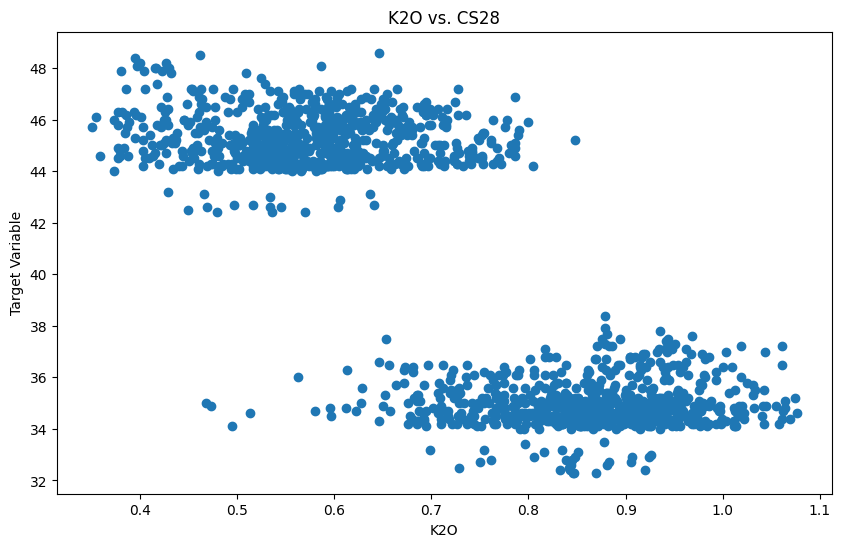

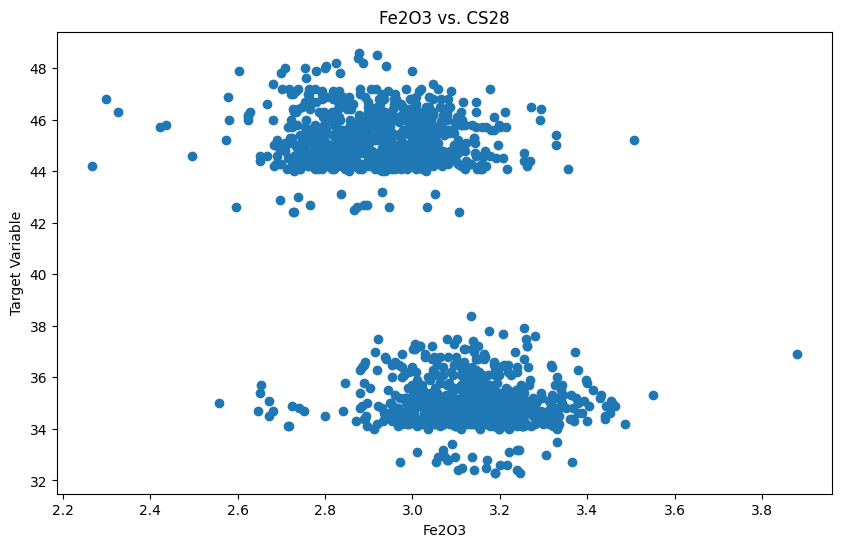

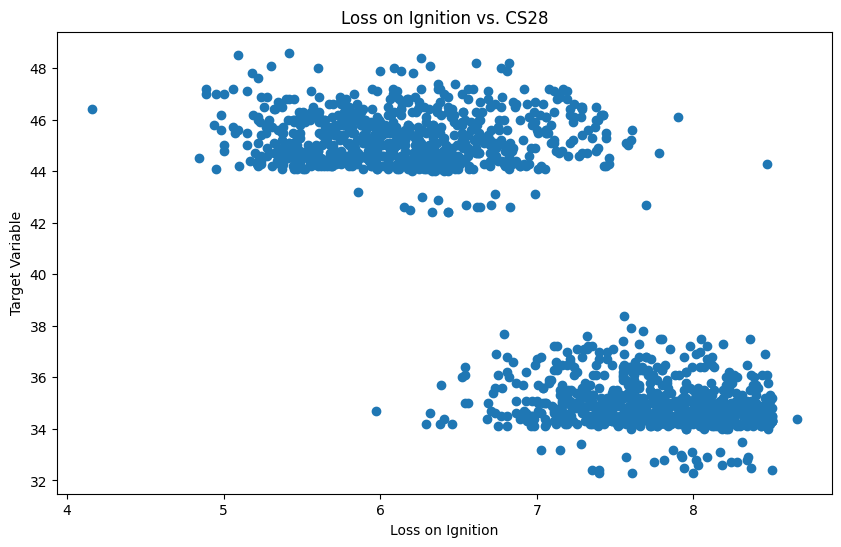

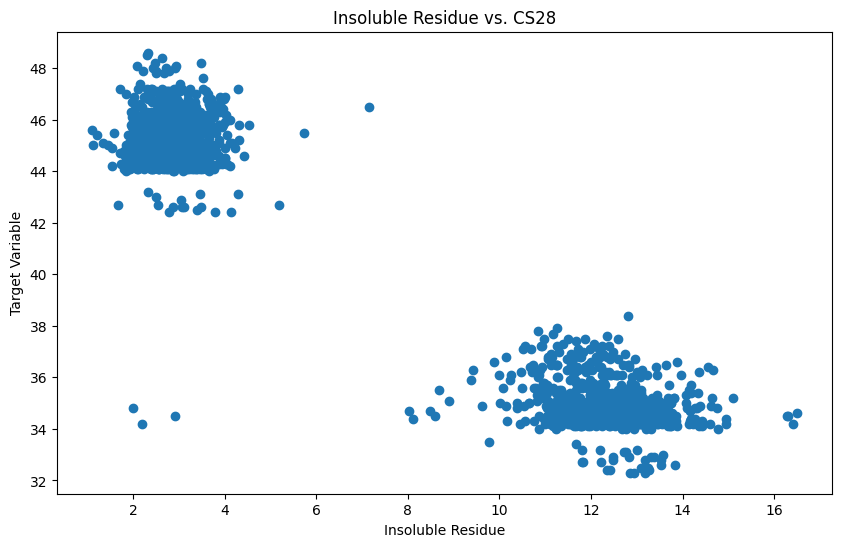

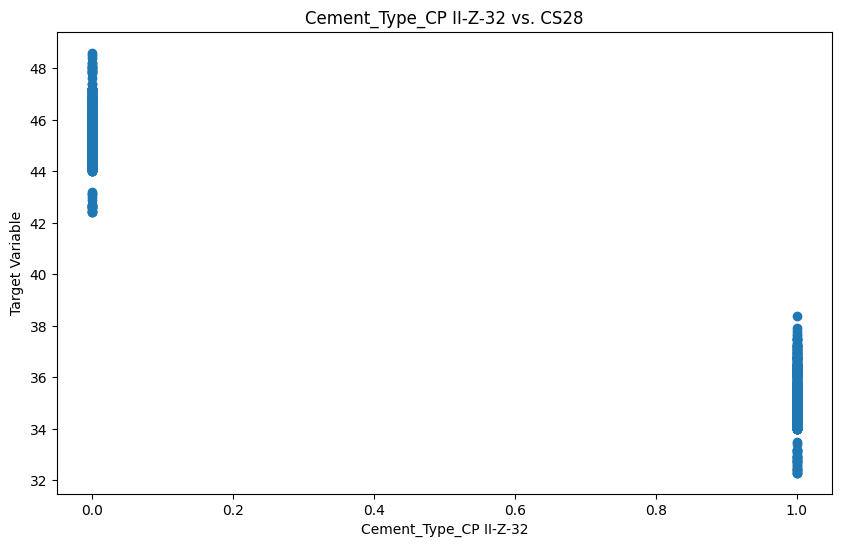

<IPython.core.display.Javascript object>

In [29]:
for column in x.drop("Date", axis=1).columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(x[column], y)
    plt.xlabel(column)
    plt.ylabel('Target Variable')
    plt.title(f'{column} vs. CS28')
    plt.show()


In [30]:
from scipy.stats import skew, kurtosis

for column in x.drop("Date", axis=1).fillna(x.drop("Date", axis=1).median()).columns:
    sk = skew(x[column].fillna(x.drop("Date", axis=1).median()))
    kt = kurtosis(x[column].fillna(x.drop("Date", axis=1).median()))
    print(f"{column}: Skewness={sk}, Kurtosis={kt}")

Free CaO: Skewness=nan, Kurtosis=nan
CaO: Skewness=nan, Kurtosis=nan
MgO: Skewness=nan, Kurtosis=nan
Na2O: Skewness=nan, Kurtosis=nan
Al2O3: Skewness=nan, Kurtosis=nan
SiO2: Skewness=nan, Kurtosis=nan
SO3: Skewness=nan, Kurtosis=nan
K2O: Skewness=nan, Kurtosis=nan
Fe2O3: Skewness=nan, Kurtosis=nan
Loss on Ignition: Skewness=nan, Kurtosis=nan
Insoluble Residue: Skewness=nan, Kurtosis=nan
Cement_Type_CP II-Z-32: Skewness=0.004013386006981917, Kurtosis=-1.9999838927327585


<IPython.core.display.Javascript object>

In [31]:
skew(x["CaO"].fillna(x.drop("Date", axis=1).median()))


nan

<IPython.core.display.Javascript object>

In [32]:
x.drop("Date", axis=1).fillna(x.drop("Date", axis=1).median()).isna().sum()

Free CaO                  0
CaO                       0
MgO                       0
Na2O                      0
Al2O3                     0
SiO2                      0
SO3                       0
K2O                       0
Fe2O3                     0
Loss on Ignition          0
Insoluble Residue         0
Cement_Type_CP II-Z-32    0
dtype: int64

<IPython.core.display.Javascript object>

In [33]:
# import statsmodels.api as sm

# decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=12)
# decomposition.plot()
# plt.show()


<IPython.core.display.Javascript object>

In [34]:
# x['log_feature'] = np.log1p(x['feature'])
# np.log1p(x["CS28"])

<IPython.core.display.Javascript object>

In [35]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=0.95)  # Retain 95% variance
# x_pca = pca.fit_transform(x.drop("Date", axis=1))


<IPython.core.display.Javascript object>

# Transformer Encoder

In [36]:
params = get_transformer_params(
    timesteps=1,
    num_features=x.shape[-1],
    num_heads=3,
    num_layers_enc=4,
    num_feed_forward=256,
    dropout_rate=0.1,
    activation="relu",
    batch_size=16,
    epochs=300,
    callbacks=None,
    validation_split=0.0,
    verbose=0,
)

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [37]:
start = time.time()

repeats = 3
n_splits = 5
train_size = 0.8
TIMESTEPS_LIST = [1]
REPEAT = 0
filenames_lists = {}
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()

for timesteps in TIMESTEPS_LIST:
    set_seeds()
    scores_final = None

    params["timesteps"] = timesteps

    for repeat in range(repeats):
        REPEAT = repeat
        x = df_copy.drop(["Date", "CS28"] + CEMENT_TYPES, axis=1)
        y = df_copy["CS28"]
        params["num_features"] = x.shape[-1]

        cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)

        filenames_list, scores = custom_cross_validate_parallelized(
            TransformerWrapper,
            SimpleImputer,
            StandardScaler,
            x,
            y,
            cv,
            timesteps,
            dates=dates,
            cement_types=df_copy[CEMENT_TYPES],
            estimator_params={"params": params},
            imputer_params={"strategy": "median"},
            split_by_cement_type=True,
            REPEAT=REPEAT,
        )
        filenames_lists[repeat] = filenames_list
        scores = scores[0]
        if scores_final is None:
            scores_final = {key: [] for key, _ in scores.items()}

        for key, value in scores.items():
            scores_final[key] += [value]

    print("TIMESTEPS: %d " % timesteps)
    print_scores(scores_final, METRICS, METRICS_DICT)

    # Saving the results
    scores = {key: np.array(val).flatten() for key, val in scores_final.items()}
    results_dict_copy = results_dict.copy()
    results_dict_copy["Timesteps"] = timesteps
    results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
    results_dict_copy[
        "Cross Validation Params"
    ] = '{"N_Splits": 5, "Repeats": 3, "train_size": 0.8}'
    results_dict_copy["Data Shape"] = x.shape
    df_results = fill_results_dict(results_dict_copy, scores)
    results_to_save.append(df_results)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Blocking Time Series Split:
Repeats: 3
n_splits: 5



2024-12-01 17:40:23.122396: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 17:40:23.124696: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 17:40:23.169276: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 17:40:23.169827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 17:40:23.174332: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You m

2024-12-01 17:41:48.900134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-01 17:41:48.917883: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-01 17:41:48.919679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-01 17:41:48.922517: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-01 17:41:48.959229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-01 17:41:49.684129: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering G

TIMESTEPS: 1 
******
[TRAIN]
******
RMSE: 0.704 (0.049)
MAE: 0.545 (0.031)
MAPE: 0.014 (0.001)
R2: 0.981 (0.002)


******
[TEST]
******
RMSE: 1.162 (0.423)
MAE: 0.860 (0.236)
MAPE: 0.021 (0.006)
R2: 0.946 (0.041)


Minutes Elapsed:  4.34705570936203


<IPython.core.display.Javascript object>

In [38]:
# ======================
# lr 1e-4 | 400 epochs
# ******
# [TEST]
# ******
# RMSE: 1.383 (0.734)
# MAE: 0.973 (0.334)
# MAPE: 0.025 (0.009)
# R2: 0.913 (0.102)

# ======================
# lr 1e-4 | 300 epochs
# ******
# [TEST]
# ******
# RMSE: 1.569 (0.683)
# MAE: 1.029 (0.305)
# MAPE: 0.026 (0.008)
# R2: 0.899 (0.097)

# ======================
# lr 1e-3 | 400 epochs
# ******
# [TEST]
# ******
# RMSE: 1.163 (0.382)
# MAE: 0.852 (0.228)
# MAPE: 0.021 (0.006)
# R2: 0.948 (0.035)


# ======================
# lr 1e-3 | 300 epochs
# ******
# [TEST]
# ******
# RMSE: 1.162 (0.423)
# MAE: 0.860 (0.236)
# MAPE: 0.021 (0.006)
# R2: 0.946 (0.041)

<IPython.core.display.Javascript object>

## Plotting the Predictions

In [39]:
from tensorflow.keras.models import load_model

pipelines_final = []

for repeat in range(repeats):
    for fold in range(n_splits):
        imputer_filename = filenames_lists[repeat][fold]["imputer"]
        scaler_filename = filenames_lists[repeat][fold]["scaler"]
        model_filename = filenames_lists[repeat][fold]["model"]

        # Load the imputer
        imputer = joblib.load(imputer_filename)
        # Load the scaler
        scaler = joblib.load(scaler_filename)
        # Load the Keras model
        estimator = load_model(model_filename)

        pipelines_final.append((imputer, scaler, estimator))

2024-12-01 17:44:42.628890: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


<IPython.core.display.Javascript object>

In [40]:
indices_final = {"train": [], "test": []}

for repeat in range(repeats):
    for train, test in cv.split(x):
        indices_final["train"].extend([train])
        indices_final["test"].extend([test])

<IPython.core.display.Javascript object>

In [41]:
len(indices_final["train"])

15

<IPython.core.display.Javascript object>

In [42]:
def split_sequences_per_cement_type_helper(dataframe, timesteps, pad=False):
    """
    Create sequences per cement time
    to avoid having parts of the sequence
    of different types of cement.
    """
    if timesteps == 1:
        x, y = split_sequences(
            dataframe.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps
        )
        return x, y, dataframe[DATE]

    dates = dataframe[DATE][timesteps - 1 :]
    data = []
    dataframes = []

    for cement_type in CEMENT_TYPES:
        data.append(dataframe[dataframe[cement_type] == 1])
    data.append(dataframe[(dataframe[CEMENT_TYPES] == 0).all(axis=1)])

    for df in data:
        if pad:
            dates = df[DATE].reset_index(drop=True)
            df = pad_time_series(df, timesteps).reset_index(drop=True)
        else:
            dates = df[DATE][timesteps - 1 :].reset_index(drop=True)
        x, y = split_sequences(df.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps)
        x = pd.DataFrame({"Sequences": [sample.tolist() for sample in x]})
        y = pd.DataFrame({"Target": y})
        dataframes.append(pd.concat([dates, x, y], axis=1))

    data = pd.concat(dataframes, axis=0)
    data[DATE] = pd.to_datetime(data[DATE])
    data = data.sort_values(by=DATE).reset_index(drop=True)
    x = data["Sequences"]
    y = data["Target"].values
    x = np.array(x.tolist())
    dates = data[DATE]

    return x, y, dates

<IPython.core.display.Javascript object>

In [43]:
def generate_sequences_helper(dataset, timesteps, split_by_cement_type=False):
    if split_by_cement_type:
        (
            dataset["x_train"],
            dataset["y_train"],
            dates_train,
        ) = split_sequences_per_cement_type_helper(
            pd.concat(
                [
                    dataset["dates_train"],
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["cement_types_train"],
                    dataset["y_train"],
                ],
                axis=1,
            ),
            timesteps,
        )

        (
            dataset["x_test"],
            dataset["y_test"],
            dates_test,
        ) = split_sequences_per_cement_type_helper(
            pd.concat(
                [
                    dataset["dates_test"],
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["cement_types_test"],
                    dataset["y_test"],
                ],
                axis=1,
            ),
            timesteps,
        )
        dataset["dates_train_seq"] = dates_train
        dataset["dates_test_seq"] = dates_test
    else:
        dataset["x_train"], dataset["y_train"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["y_train"],
                ],
                axis=1,
            ).values,
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["y_test"],
                ],
                axis=1,
            ).values,
            timesteps,
        )
    return dataset

<IPython.core.display.Javascript object>

In [44]:
# Store predictions for each fold
all_predictions = []
cement_types=df_copy[CEMENT_TYPES]
params["timesteps"]=timesteps

for idx, (imputer, scaler, estimator) in enumerate(pipelines_final):
    train_index = indices_final["train"][idx]
    test_index = indices_final["test"][idx]
    
    # Prepare dataset for prediction
    dataset = {
        "dates_train": dates.iloc[train_index].reset_index(drop=True),
        "cement_types_train": cement_types.iloc[train_index].reset_index(drop=True),
        "x_train": x.iloc[train_index].reset_index(drop=True),
        "y_train": y.iloc[train_index].reset_index(drop=True),
        "dates_test": dates.iloc[test_index].reset_index(drop=True),
        "cement_types_test": cement_types.iloc[test_index].reset_index(drop=True),
        "x_test": x.iloc[test_index].reset_index(drop=True),
        "y_test": y.iloc[test_index].reset_index(drop=True),
    }

    # Apply preprocessing
    dataset["x_train"] = imputer.transform(dataset["x_train"])
    dataset["x_test"] = imputer.transform(dataset["x_test"])

    dataset["x_train"] = scaler.transform(dataset["x_train"])
    dataset["x_test"] = scaler.transform(dataset["x_test"])

    # Generate sequences
    dataset = generate_sequences_helper(dataset, params["timesteps"], split_by_cement_type=True)

    if timesteps == 1:
    # Adjust dates for sequences
        dates_train = dataset["dates_train"][params["timesteps"] - 1:].reset_index(drop=True)
        dates_test = dataset["dates_test"][params["timesteps"] - 1:].reset_index(drop=True)
    else:
        dates_train = dataset["dates_train_seq"]#.reset_index(drop=True)
        dates_test = dataset["dates_test_seq"]#.reset_index(drop=True)

    # Make predictions
    y_train_pred = estimator.predict(dataset["x_train"], verbose=0).flatten()
    y_test_pred = estimator.predict(dataset["x_test"], verbose=0).flatten()

    # Store predictions along with fold information
    fold_predictions_train = pd.DataFrame({
        "DATE": dates_train,
        "CS28": dataset["y_train"],
        "CS28_PRED": y_train_pred,
        "SET": ["TRAIN"] * len(y_train_pred),
        "FOLD": [idx + 1] * len(y_train_pred),
        "REPEAT": [(idx)//5] * len(y_train_pred),
        #"INDEX": dates_train.index.values,
    })

    fold_predictions_test = pd.DataFrame({
        "DATE": dates_test,
        "CS28": dataset["y_test"],
        "CS28_PRED": y_test_pred,
        "SET": ["TEST"] * len(y_test_pred),
        "FOLD": [idx + 1] * len(y_test_pred),
        "REPEAT": [(idx)//5] * len(y_test_pred),
        #"INDEX": dates_test.index.values,
    })

    all_predictions.append(pd.concat([fold_predictions_train, fold_predictions_test], axis=0))


<IPython.core.display.Javascript object>

In [45]:
df_pred = pd.concat(all_predictions).reset_index(drop=True)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

mean = pd.concat(
    [
        df_pred[df_pred["REPEAT"].eq(0)]["CS28_PRED"].reset_index(drop=True),
        df_pred[df_pred["REPEAT"].eq(1)]["CS28_PRED"].reset_index(drop=True),
        df_pred[df_pred["REPEAT"].eq(2)]["CS28_PRED"].reset_index(drop=True),
    ],
    axis=1,
).mean(axis=1)

df_copy_merge = (
    df_copy.drop(["Cement_Type_CP II-Z-32", "CS28"], axis=1)
    .merge(df_pred, left_index=True, right_index=True, how="left")
    .drop("REPEAT", axis=1)
)

df_copy_merge["COMPANY"] = 209
df_copy_merge["PLANT"] = "S"
df_copy_merge["CS28_PRED"] = mean

df_copy_merge.to_excel("global_model_transformer_1ts_btsscv_209_s.xlsx", index=False)
df_copy_merge.to_csv("global_model_transformer_1ts_btsscv_209_s.csv", index=False)

<IPython.core.display.Javascript object>

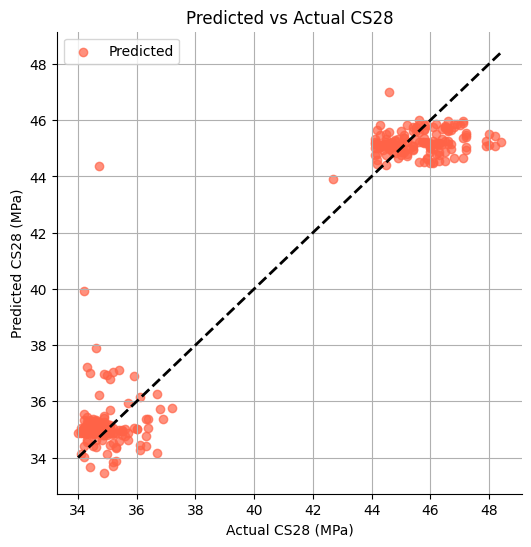

<IPython.core.display.Javascript object>

In [46]:
df_pred = pd.concat(all_predictions).reset_index(drop=True)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

# Proceed with your plotting code
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]

test_data_tmp = test_data[test_data["REPEAT"].eq(0)].copy().reset_index(drop=True)

mean = pd.concat(
    [test_data[test_data["REPEAT"].eq(0)]["CS28_PRED"].reset_index(drop=True),
    test_data[test_data["REPEAT"].eq(1)]["CS28_PRED"].reset_index(drop=True),
    test_data[test_data["REPEAT"].eq(2)]["CS28_PRED"].reset_index(drop=True)],
axis=1).mean(axis=1)

test_data_tmp["CS28_PRED"] = mean
test_data = test_data_tmp

# test_data = test_data.groupby("INDEX", as_index=False).agg(
#     {"DATE": "first", "CS28": "first", "CS28_PRED": "mean", "SET": "first", "FOLD": "first"}
# )
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_global_cm_btiss_fine_tuning_dominant_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches="tight"
)
plt.show()


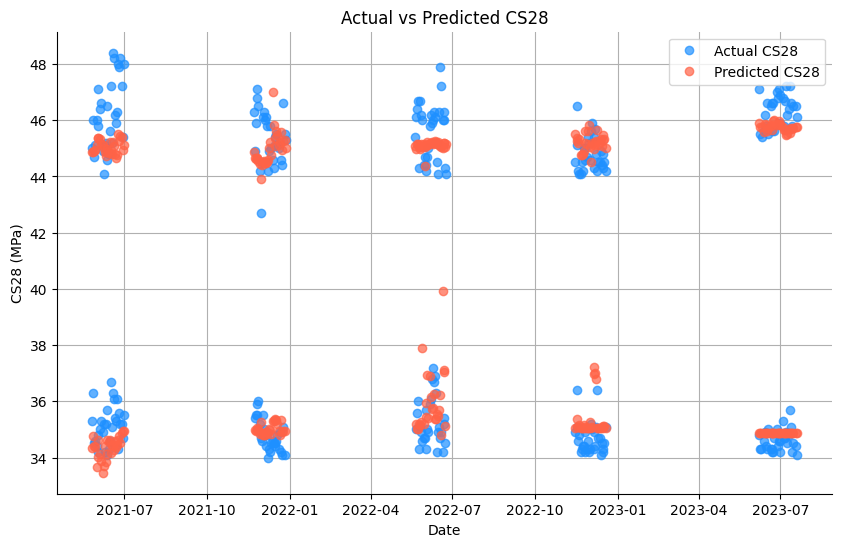

<IPython.core.display.Javascript object>

In [47]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
#plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_global_cm_btiss_fine_tuning_dominant_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


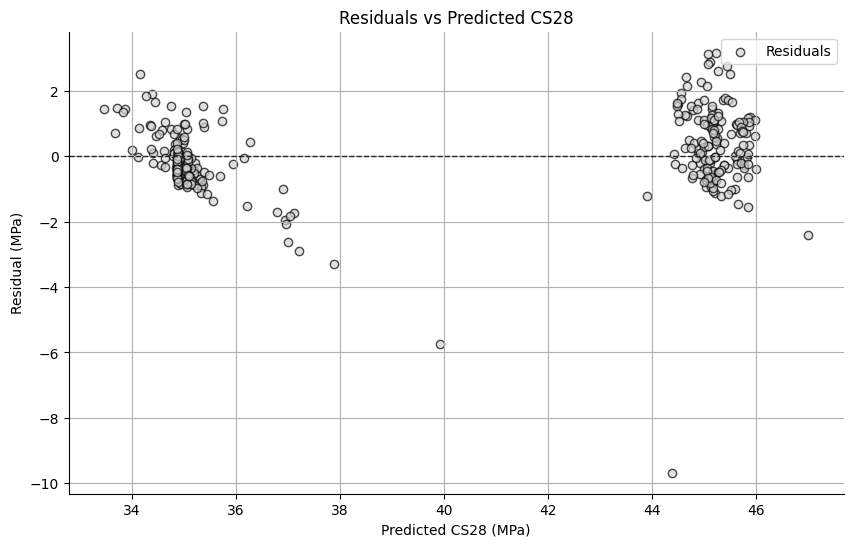

<IPython.core.display.Javascript object>

In [48]:
test_data["RESIDUAL"] = test_data["CS28"] - test_data["CS28_PRED"]

plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="lightgray",
    alpha=0.7,
    edgecolor="black",
    label="Residuals"
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_btiss_top_one_fine_tuning_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


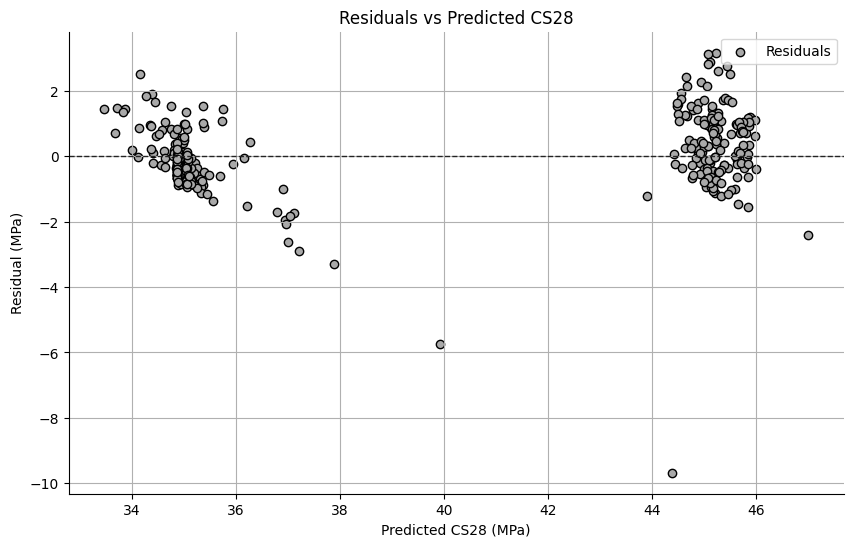

<IPython.core.display.Javascript object>

In [49]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="darkgray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
# plt.savefig(
#     "ecics_global_cm_btiss_top_one_fine_tuning_residuals_vs_predicted.png",
#     dpi=300,
#     bbox_inches="tight",
# )

plt.show()

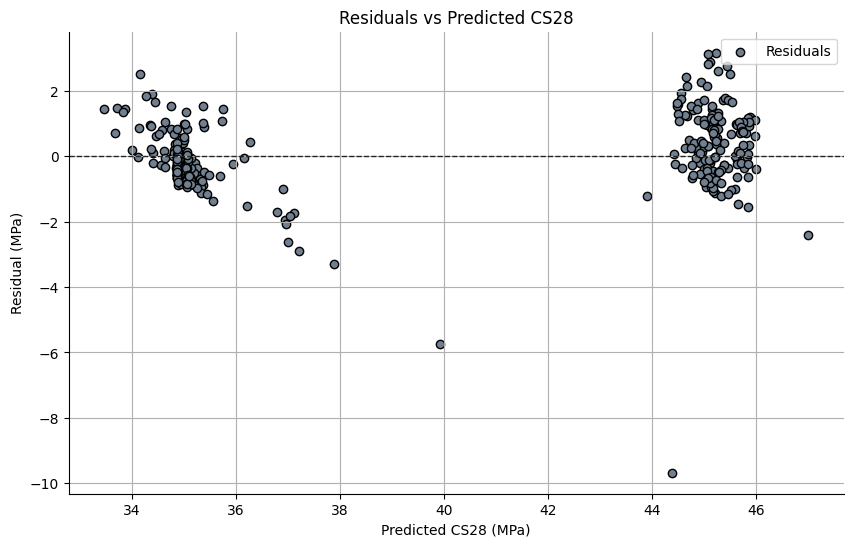

<IPython.core.display.Javascript object>

In [50]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="slategray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
# plt.savefig(
#     "ecics_global_cm_btiss_top_one_fine_tuning_residuals_vs_predicted.png",
#     dpi=300,
#     bbox_inches="tight",
# )

plt.show()

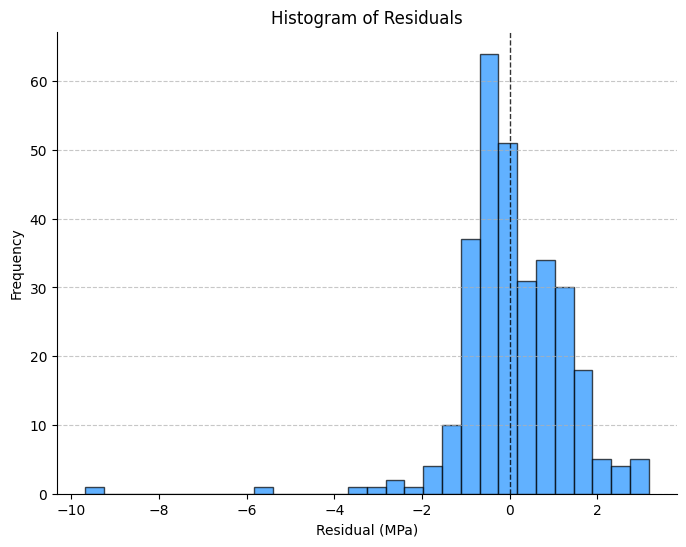

<IPython.core.display.Javascript object>

In [51]:
plt.figure(figsize=(8, 6))

# Plot histogram of residuals
plt.hist(
    test_data["RESIDUAL"],
    bins=30,  # Number of bins for better granularity
    color="dodgerblue",
    edgecolor="black",
    alpha=0.7
)

# Add labels and title
plt.xlabel("Residual (MPa)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

# Add a vertical line at 0 for reference
plt.axvline(x=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Remove top and right spines for cleaner aesthetics
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the plot
plt.savefig(
    "ecics_global_cm_btiss_dominant_top_one_fine_tuning_residual_histogram.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


# Feature Importance

In [52]:
def permutation_importance_seq(model, X, y, metric, n_repeats=5):
    """
    Computes permutation importance for sequence models with 3D input.
    """
    baseline_score = metric(y, model.predict(X))
    num_features = X.shape[2]  # Number of features
    importances = np.zeros(num_features)
    set_seeds()
    for i in range(num_features):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            # Shuffle feature i across samples, keeping time steps intact
            for t in range(X.shape[1]):
                # Extract the feature values at time t
                feature_values = X_permuted[:, t, i]
                np.random.shuffle(feature_values)
                X_permuted[:, t, i] = feature_values
            # Compute metric with permuted data
            permuted_score = metric(y, model.predict(X_permuted, verbose=0))
            scores.append(permuted_score)
        # Importance is the increase in metric when the feature is permuted
        importances[i] = baseline_score - np.mean(scores)
    return importances

<IPython.core.display.Javascript object>

In [53]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tqdm import tqdm

feature_importances = []

for idx, (imputer, scaler, estimator) in tqdm(enumerate(pipelines_final)):
    train_index = indices_final["train"][idx]
    x_train = x.iloc[train_index].reset_index(drop=True)
    y_train = y.iloc[train_index].reset_index(drop=True)

    test_index = indices_final["test"][idx]
    x_test = x.iloc[test_index].reset_index(drop=True)
    y_test = y.iloc[test_index].reset_index(drop=True)

    # Preprocess x_test
    x_test_imputed = imputer.transform(x_test)
    x_test_scaled = scaler.transform(x_test_imputed)

    # Generate sequences
    dataset = {
        "x_train": x_test_scaled,
        "y_train": y_test,
        "x_test": x_test_scaled,
        "y_test": y_test,
    }
    dataset = generate_sequences(
        dataset, params["timesteps"], split_by_cement_type=False
    )
    x_test_seq = dataset["x_test"]
    y_test_seq = dataset["y_test"]

    # Compute permutation importance
    importances = permutation_importance_seq(
        estimator, x_test_seq, y_test_seq, r2_score, n_repeats=10
    )
    feature_importances.append(importances)

0it [00:00, ?it/s]

2/2 [==============================] - 0s 6ms/step


1it [00:07,  7.77s/it]

2/2 [==============================] - 0s 8ms/step


2it [00:14,  7.42s/it]

2/2 [==============================] - 0s 8ms/step


3it [00:22,  7.29s/it]

2/2 [==============================] - 0s 7ms/step


4it [00:29,  7.23s/it]

2/2 [==============================] - 0s 8ms/step


5it [00:36,  7.25s/it]

2/2 [==============================] - 0s 9ms/step


6it [00:43,  7.29s/it]

2/2 [==============================] - 0s 9ms/step


7it [00:51,  7.36s/it]

2/2 [==============================] - 0s 8ms/step


8it [00:58,  7.37s/it]

2/2 [==============================] - 0s 9ms/step


9it [01:06,  7.34s/it]

2/2 [==============================] - 0s 7ms/step


10it [01:13,  7.29s/it]

2/2 [==============================] - 0s 9ms/step


11it [01:20,  7.26s/it]

2/2 [==============================] - 0s 8ms/step


12it [01:27,  7.33s/it]

2/2 [==============================] - 0s 8ms/step


13it [01:35,  7.38s/it]

2/2 [==============================] - 0s 7ms/step


14it [01:42,  7.42s/it]

2/2 [==============================] - 0s 8ms/step


15it [01:50,  7.34s/it]


<IPython.core.display.Javascript object>

In [54]:
import numpy as np
import pandas as pd

# Average importances across folds
mean_importances = np.mean(feature_importances, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(feature_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

In [55]:
rename_dict = {
    "K2O": r"$\mathrm{K_2O}$",
    "Free CaO": r"Free $\mathrm{CaO}$",
    "Total C2S": r"Total $\mathrm{C_2S}$",
    "Na2O": r"$\mathrm{Na_2O}$",
    "CaO": r"$\mathrm{CaO}$",
    "SiO2": r"$\mathrm{SiO_2}$",
    "MgO": r"$\mathrm{MgO}$",
    "Fe2O3": r"$\mathrm{Fe_2O_3}$",
    "Al2O3": r"$\mathrm{Al_2O_3}$",
    "Total C3S": r"Total $\mathrm{C_3S}$",
    "C3A": r"$\mathrm{C_3A}$",
    "C4AF": r"$\mathrm{C_4AF}$",
    "LOI": "LOI",
    "SO3": r"$\mathrm{SO_3}$",
    "Insoluble Residue": "IR",
}

importances_df = importances_df.rename(rename_dict, axis=1)
importances_df_mean["Feature"] = importances_df_mean["Feature"].replace(rename_dict)

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


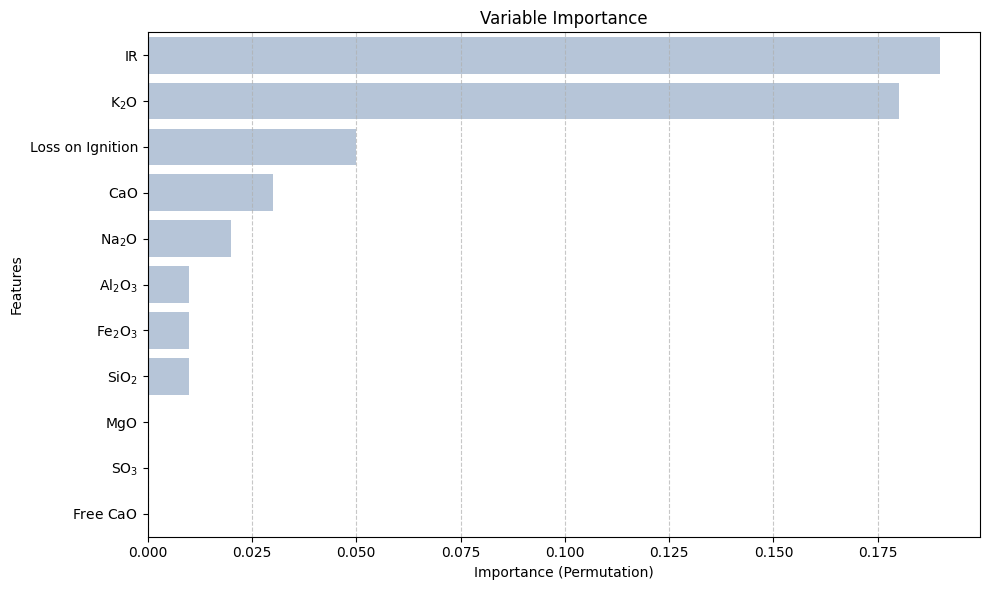

<IPython.core.display.Javascript object>

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort importances
mean_importances_df = importances_df_mean.sort_values(by='Importance', ascending=False).round(2)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=mean_importances_df, color="lightsteelblue")
plt.title("Variable Importance")
plt.xlabel("Importance (Permutation)")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
# plt.savefig(
#     "variable_relevance.png",
#     dpi=300,
#     bbox_inches="tight",
# )
plt.show()


/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

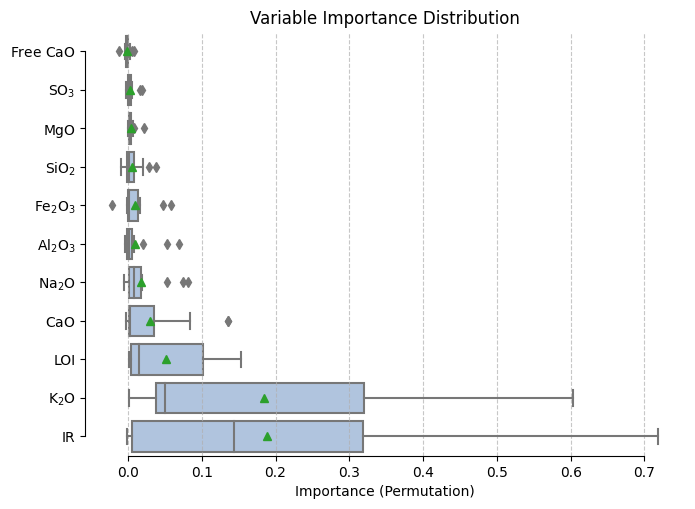

<IPython.core.display.Javascript object>

In [57]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_global_cm_btiss_fine_tuning_transformer_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

In [58]:
perm_importances_df.describe().T

count      mean       std       min       25%       50%  \
Free $\mathrm{CaO}$   15.0 -0.001192  0.004556 -0.012257 -0.002897 -0.001537   
$\mathrm{SO_3}$       15.0  0.003306  0.006248 -0.002024 -0.000033  0.001079   
$\mathrm{MgO}$        15.0  0.003797  0.005319 -0.000125  0.000991  0.002548   
$\mathrm{SiO_2}$      15.0  0.005376  0.013757 -0.009967 -0.000787  0.000931   
$\mathrm{Fe_2O_3}$    15.0  0.009133  0.019922 -0.020985 -0.000070  0.001137   
$\mathrm{Al_2O_3}$    15.0  0.010152  0.021622 -0.003745 -0.001055  0.001070   
$\mathrm{Na_2O}$      15.0  0.017744  0.028241 -0.005319  0.001912  0.007918   
$\mathrm{CaO}$        15.0  0.030483  0.048779 -0.002029  0.000925  0.002800   
Loss on Ignition      15.0  0.051917  0.059175  0.000746  0.003822  0.015495   
$\mathrm{K_2O}$       15.0  0.184448  0.209197  0.001184  0.037623  0.050867   
IR                    15.0  0.188288  0.212497 -0.001313  0.005189  0.143272   

                          75%       max  
Free $\mathrm{CaO}$ -0.000146  0.008152  
$\mathrm{SO_3}$      0.003721  0.019560  
$\mathrm{MgO}$       0.003738  0.021106  
$\mathrm{SiO_2}$     0.008839  0.037882  
$\mathrm{Fe_2O_3}$   0.013069  0.058631  
$\mathrm{Al_2O_3}$   0.005895  0.069114  
$\mathrm{Na_2O}$     0.017794  0.081031  
$\mathrm{CaO}$       0.035955  0.136039  
Loss on Ignition     0.102299  0.152739  
$\mathrm{K_2O}$      0.319639  0.602901  
IR                   0.318928  0.718330

<IPython.core.display.Javascript object>

# Analysis of predictions on the Global Dataset

*The model is the same. However We'll show the predictions of it on the global dataset*

## Reading the dataset

In [59]:
df = pd.read_csv("../../../../data/processed/209/global_s.csv")

<IPython.core.display.Javascript object>

## Defining the features

In [60]:
df_copy = df.copy()
df_copy = pd.get_dummies(data=df_copy, columns=["Cement_Type"], drop_first=True)

df_copy = df_copy.drop(
    [
        # "Cement_Type",
        "Factory_Plant",
        "Blaine",
        "#400",
        "Final setting time",
        "Initial setting time",
        "CS3",
        "CS7",
    ],
    axis=1,
)

# df_copy["Date"] = pd.to_datetime(df_copy["Date"])

<IPython.core.display.Javascript object>

In [61]:
df_copy[CEMENT_TYPES] = df_copy[CEMENT_TYPES].astype(int)
dates = df["Date"].copy()
y = df_copy.pop("CS28")
x = df_copy
df_copy = pd.concat([x, y], axis=1)

<IPython.core.display.Javascript object>

In [62]:
def prepare_dataset(
    dataframe_original=df,
    dataframe_copy=df_copy,
    train_size=0.8,
    test_size=0.2,
    ignore_test_set=False,
    timesteps=1,
    split_by_cement_type=True,
):
    dataframe_original = df.copy()
    dataframe_copy = df_copy.copy()
    dataframe_copy[CEMENT_TYPES] = dataframe_copy[CEMENT_TYPES].astype(int).copy()
    dates = dataframe_original["Date"].copy()
    x = dataframe_copy.drop(["Date", "CS28"] + CEMENT_TYPES, axis=1)
    y = dataframe_copy["CS28"]
    cement_types = dataframe_copy[CEMENT_TYPES].copy()

    if not ignore_test_set:
        train_index = x.loc[: x.shape[0] * train_size].index
        test_index = x.loc[train_index[-1] + 1 :].index
    else:
        train_index = x.loc[: x.shape[0] * train_size].index
        test_index = x.loc[train_index[-1] + 1 :].index

    dataset = {
        "dates_train": dates[train_index].reset_index(drop=True).copy(),
        "cement_types_train": cement_types.loc[train_index]
        .reset_index(drop=True)
        .copy(),
        "x_train": x.loc[train_index].reset_index(drop=True).copy(),
        "y_train": y[train_index].reset_index(drop=True).copy(),
        "dates_test": dates[test_index].reset_index(drop=True).copy(),
        "cement_types_test": cement_types.loc[test_index].reset_index(drop=True).copy(),
        "x_test": x.loc[test_index].reset_index(drop=True).copy(),
        "y_test": y[test_index].reset_index(drop=True).copy(),
    }

    # Preprocess the dataset
    dataset = preprocess_data(dataset, None, SimpleImputer, {"strategy": "median"})

    # generate sequences (3D format)
    dataset = generate_sequences(
        dataset, timesteps=timesteps, split_by_cement_type=split_by_cement_type
    )

    return dataset

<IPython.core.display.Javascript object>

In [63]:
def impute_data(dataset, imputer=None, imputer_params=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply imputation to the data
    if imputer is not None:
        imputer = imputer() if imputer_params is None else imputer(**imputer_params)
        x_train = imputer.fit_transform(x_train)
        x_test = imputer.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return dataset

<IPython.core.display.Javascript object>

In [64]:
def transform_data(dataset, transformer=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply data normalization/standardization to the data
    if transformer is not None:
        scaler = transformer()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return dataset

<IPython.core.display.Javascript object>

In [65]:
def preprocess_data(dataset, transformer=None, imputer=None, imputer_params=None):
    dataset = impute_data(dataset, imputer, imputer_params)
    dataset = transform_data(dataset, transformer)
    return dataset

<IPython.core.display.Javascript object>

In [66]:
def get_transformer_params(
    timesteps=1,
    num_features=x.shape[-1],
    num_heads=1,
    num_layers_enc=1,
    num_feed_forward=16,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=None,
    validation_split=0.0,
    verbose=0,
):
    params = {}
    params["num_features"] = x.shape[-1]
    params["timesteps"] = timesteps
    params["num_heads"] = num_heads
    params["num_layers_enc"] = num_layers_enc
    params["num_feed_forward"] = num_feed_forward
    params["verbose"] = verbose
    params["dropout_rate"] = dropout_rate
    params["activation"] = activation
    params["batch_size"] = batch_size
    params["epochs"] = epochs
    params["callbacks"] = callbacks
    params["validation_split"] = validation_split

    return params

<IPython.core.display.Javascript object>

In [67]:
class TransformerWrapper(RegressorMixin):
    def __init__(self, params):
        self.params = params
        self.model = self.get_model()
        self.batch_size = self.params.get("batch_size", 16)
        self.epochs = self.params.get("epochs", 300)
        self.verbose = self.params.get("verbose", 0)
        self.callbacks = self.params.get("callbacks", None)
        self.validation_split = self.params.get("validation_split", 0.0)
        self.num_features = self.params.get("num_features", x.shape[-1])
        dummy_input_shape = (
            self.batch_size,
            self.params["timesteps"],
            self.num_features,
        )
        self.model.build(dummy_input_shape)

    def fit(self, X=None, y=None):
        self.model.build(X.shape)
        self.load_pretrained_weights()
        self.history = self.model.fit(
            X,
            y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            validation_split=self.validation_split,
        )

    def predict(self, X=None, verbose=0):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = Transformer(
            num_hid=self.params["num_features"],
            time_steps=self.params["timesteps"],
            num_head=self.params["num_heads"],
            num_layers_enc=self.params["num_layers_enc"],
            num_feed_forward=self.params["num_feed_forward"],
            dropout_rate=self.params.get("dropout_rate", 0.1),
            activation=self.params.get("activation", "relu"),
        )
        model.compile(
            tf.keras.optimizers.Adam(learning_rate=0.001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

    def load_pretrained_weights(self, freeze_layers=0):
        # Load global weights
        self.model.load_weights(full_path)

        # Freeze layers
        for layer in self.model.layers[:freeze_layers]:
            layer.trainable = False
        if freeze_layers > 0:
            self.model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                loss="mse",
                metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
            )
        return

    def save(self, filepath):
        self.model.save(filepath)

<IPython.core.display.Javascript object>

In [68]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}
DATE = "Date"
CEMENT_TYPES = [
    "Cement_Type_CP I-S-40",
    "Cement_Type_CP II-E-32",
    "Cement_Type_CP II-E-40",
    "Cement_Type_CP II-F-32",
    "Cement_Type_CP II-F-40",
    "Cement_Type_CP II-Z-32",
    "Cement_Type_CP II-Z-40",
    "Cement_Type_CP III-32",
    "Cement_Type_CP III-32 RS",
    "Cement_Type_CP III-40",
    "Cement_Type_CP III-40 RS",
    "Cement_Type_CP IV-32",
    "Cement_Type_CP IV-32 RS",
    "Cement_Type_CP V-ARI",
    "Cement_Type_CP V-ARI RS",
    "Cement_Type_Fibrocimento",
    "Cement_Type_CP I-40",
]

<IPython.core.display.Javascript object>

In [69]:
df_copy.shape

(61946, 30)

<IPython.core.display.Javascript object>

In [70]:
df_copy[CEMENT_TYPES] = df_copy[CEMENT_TYPES].astype(int)
dates = df["Date"].copy()
y = df_copy.pop("CS28")
x = df_copy
df_copy = pd.concat([x, y], axis=1)
x = x.drop(["Date"] + CEMENT_TYPES, axis=1)

<IPython.core.display.Javascript object>

In [71]:
weights_path = "../../../../models/global_models/209/transformer/am/pre_training/"
model_name = ""
full_path = os.path.join(weights_path, model_name)

timesteps = 1
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=3,
    num_layers_enc=4,
    num_feed_forward=256,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

# Instantiate the model
model = TransformerWrapper(params)
model.load_pretrained_weights()

# Making predictions on train/test sets
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Return regression metrics
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.431 (0.000)
MAE: 1.748 (0.000)
MAPE: 0.040 (0.000)
R2: 0.873 (0.000)


******
[TEST]
******
RMSE: 2.948 (0.000)
MAE: 2.137 (0.000)
MAPE: 0.051 (0.000)
R2: 0.759 (0.000)




<IPython.core.display.Javascript object>

In [72]:
61946 * 0.2

12389.2

<IPython.core.display.Javascript object>

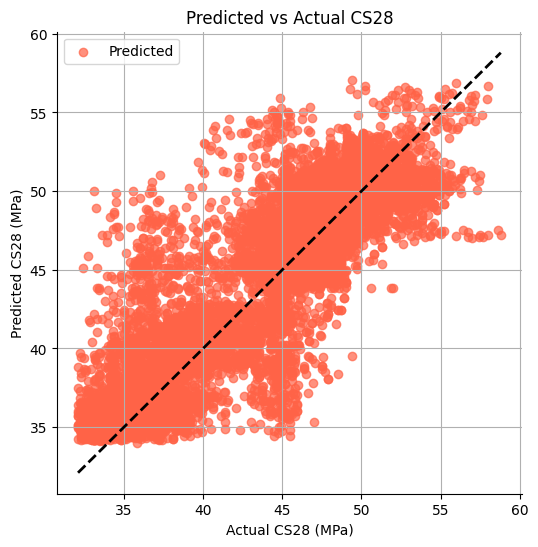

<IPython.core.display.Javascript object>

In [73]:
test_data = pd.DataFrame(
    {
        "DATE": dataset["dates_test"],
        "CS28": dataset["y_test"],
        "CS28_PRED": y_test_pred.squeeze(),
    }
)
test_data = test_data[test_data["CS28"] > 32]

plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_global_cm_btiss_pre_train_dominant_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [74]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# # Convert dates to datetime if they aren't already
# train_data = pd.DataFrame(
#     {
#         "DATE": pd.to_datetime(dataset["dates_train"]),
#         "CS28": dataset["y_train"].squeeze(),
#     }
# )

# test_data = pd.DataFrame(
#     {
#         "DATE": pd.to_datetime(dataset["dates_test"]),
#         "CS28": dataset["y_test"].squeeze(),
#         "CS28_PRED": y_test_pred.squeeze(),
#     }
# )

# plt.figure(figsize=(10, 6))


# # Plot training data up to test_start_date
# plt.plot(
#     train_data["DATE"],
#     train_data["CS28"],
#     color="dodgerblue",
#     alpha=0.7,
#     marker="o",
#     linestyle="none",
#     label="Actual CS28",
#     markersize=6,
# )

# # Plot test predictions strictly after test_start_date
# plt.plot(
#     test_data["DATE"],
#     test_data["CS28_PRED"],
#     color="tomato",
#     alpha=0.7,
#     marker="o",
#     linestyle="none",
#     label="Predicted CS28",
#     markersize=6,
# )

# # Add vertical line exactly at the start of test data first (so it's behind the points)
# test_start_date = test_data["DATE"].iloc[0]  # Get the exact first date of test data
# test_start_date = pd.to_datetime(test_data["DATE"].iloc[0]) - pd.DateOffset(days=10)
# plt.axvline(x=test_start_date, color="gray", linestyle="--", alpha=1.0)

# plt.xlabel("Date")
# plt.ylabel("CS28 (MPa)")
# plt.title("Actual CS28 (Full Series) vs Predicted CS28 (Test Period)")
# plt.legend()
# plt.grid(True)

# # Improving x-axis readability with 2-month intervals
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
# plt.gcf().autofmt_xdate(rotation=45)

# # Remove top and right spines
# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

# # Save the figure
# plt.savefig(
#     "ecics_global_cm_btiss_pre_train_dominant_full_series_with_predictions.png",
#     dpi=300,
#     bbox_inches="tight",
# )

# plt.show()

<IPython.core.display.Javascript object>

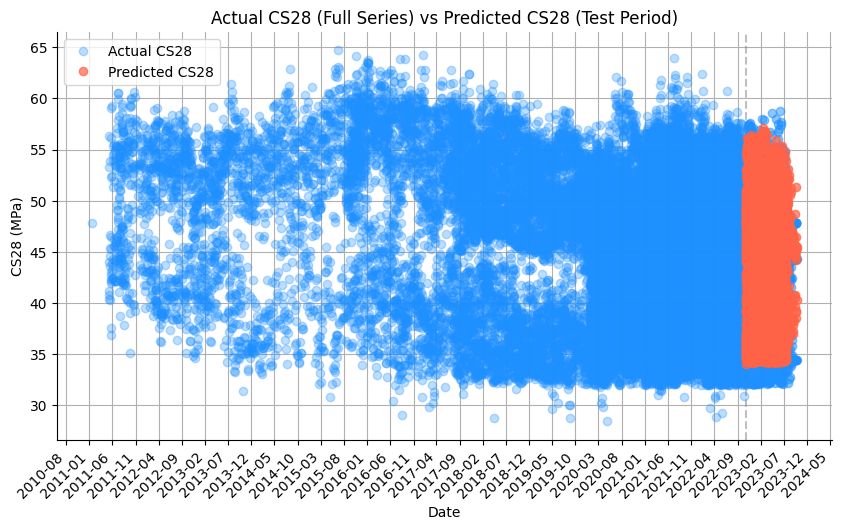

<IPython.core.display.Javascript object>

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert dates to datetime if they aren't already
train_data = pd.DataFrame({
    "DATE": pd.to_datetime(dataset["dates_train"]),
    "CS28": dataset["y_train"].squeeze()
})

test_data = pd.DataFrame({
    "DATE": pd.to_datetime(dataset["dates_test"]),
    "CS28": dataset["y_test"].squeeze(),
    "CS28_PRED": y_test_pred.squeeze()
})

test_data = test_data[test_data["CS28"] >32]

plt.figure(figsize=(10, 6))

# Add vertical line exactly at the start of test data first (so it's behind the points)
test_start_date = test_data["DATE"].iloc[0]  # Get the exact first date of test data
plt.axvline(x=test_start_date, color='gray', linestyle='--', alpha=0.5)

# Plot complete actual data (both train and test)
plt.plot(
    train_data["DATE"], 
    train_data["CS28"],
    color="dodgerblue",
    alpha=0.3,
    marker="o",
    linestyle="none",
    label="Actual CS28",
    markersize=6
)

# Plot actual test data
plt.plot(
    test_data["DATE"], 
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.5,
    marker="o",
    linestyle="none",
    markersize=6
)

# Plot test predictions
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
    markersize=6
)

plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual CS28 (Full Series) vs Predicted CS28 (Test Period)")
plt.legend()
plt.grid(True)

# Improving x-axis readability with 2-month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate(rotation=45)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_btiss_pre_train_dominant_full_series_with_predictions.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


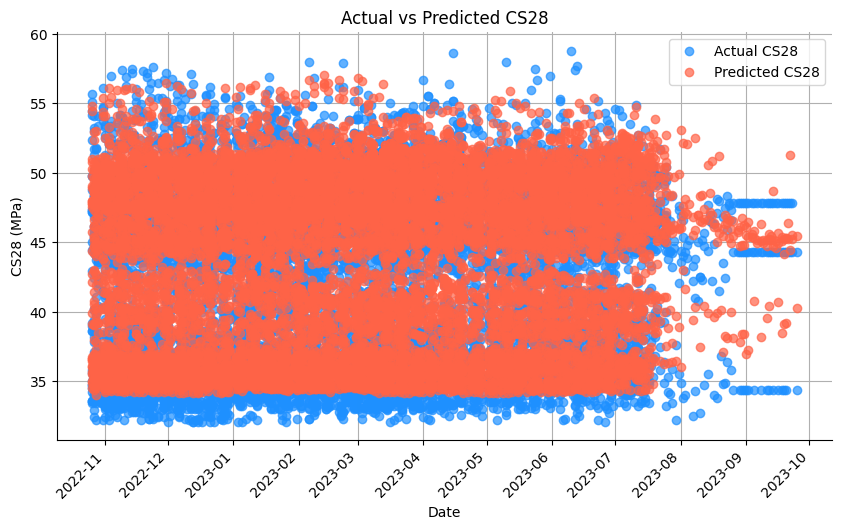

<IPython.core.display.Javascript object>

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert dates to datetime if they aren't already
train_data = pd.DataFrame(
    {
        "DATE": pd.to_datetime(dataset["dates_train"]),
        "CS28": dataset["y_train"].squeeze(),
    }
)

test_data = pd.DataFrame(
    {
        "DATE": pd.to_datetime(dataset["dates_test"]),
        "CS28": dataset["y_test"].squeeze(),
        "CS28_PRED": y_test_pred.squeeze(),
    }
)

test_data = test_data[test_data["CS28"] > 32]


plt.figure(figsize=(10, 6))

# Add vertical line exactly at the start of test data first (so it's behind the points)
# test_start_date = test_data["DATE"].iloc[0]  # Get the exact first date of test data
# plt.axvline(x=test_start_date, color="gray", linestyle="--", alpha=0.5)


# Plot actual test data
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
    markersize=6,
)

# Plot test predictions
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
    markersize=6,
)

plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
# plt.title("Actual CS28 (Full Series) vs Predicted CS28 (Test Period)")
plt.title("Actual vs Predicted CS28")

plt.legend()
plt.grid(True)

# Improving x-axis readability with 2-month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate(rotation=45)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_btiss_pre_train_dominant_pred_vs_actual_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

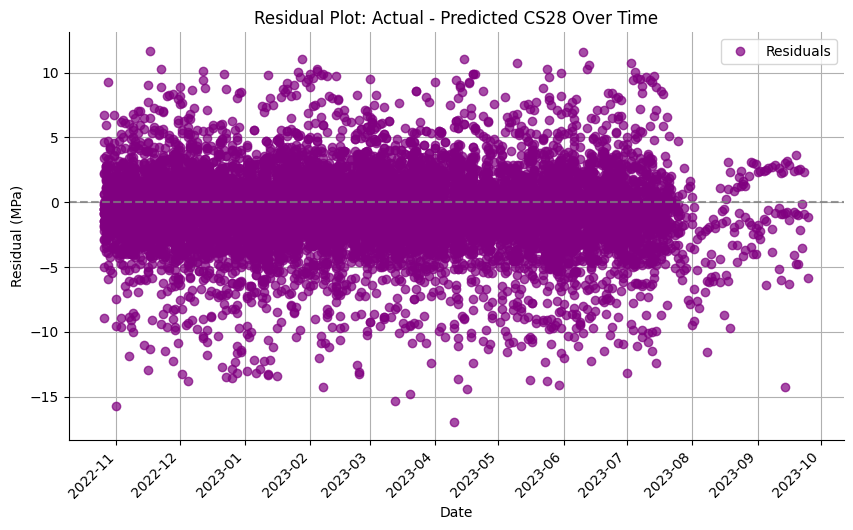

<IPython.core.display.Javascript object>

In [77]:
# Calculate residuals
test_data["RESIDUAL"] = test_data["CS28"] - test_data["CS28_PRED"]

plt.figure(figsize=(10, 6))

# Plot residuals over time
plt.plot(
    test_data["DATE"],
    test_data["RESIDUAL"],
    color="purple",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Residuals",
    markersize=6,
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="gray", linestyle="--", alpha=0.8)

plt.xlabel("Date")
plt.ylabel("Residual (MPa)")
plt.title("Residual Plot: Actual - Predicted CS28 Over Time")
plt.legend()
plt.grid(True)

# Improve x-axis readability with 2-month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate(rotation=45)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_btiss_residuals_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


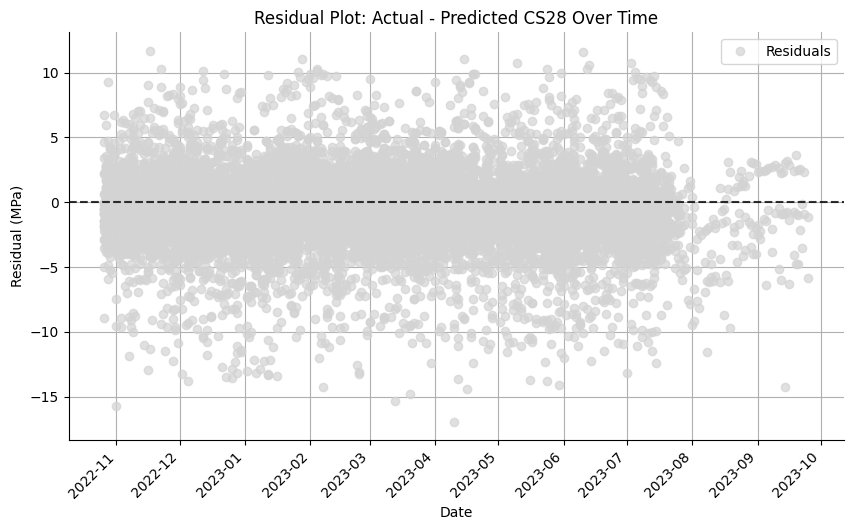

<IPython.core.display.Javascript object>

In [78]:
# Calculate residuals
test_data["RESIDUAL"] = test_data["CS28"] - test_data["CS28_PRED"]

plt.figure(figsize=(10, 6))

# Plot residuals over time with a light gray color
plt.plot(
    test_data["DATE"],
    test_data["RESIDUAL"],
    color="lightgray",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Residuals",
    markersize=6,
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", alpha=0.8)

plt.xlabel("Date")
plt.ylabel("Residual (MPa)")
plt.title("Residual Plot: Actual - Predicted CS28 Over Time")
plt.legend()
plt.grid(True)

# Improve x-axis readability with 2-month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate(rotation=45)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_btiss_residuals_over_time_graylight.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


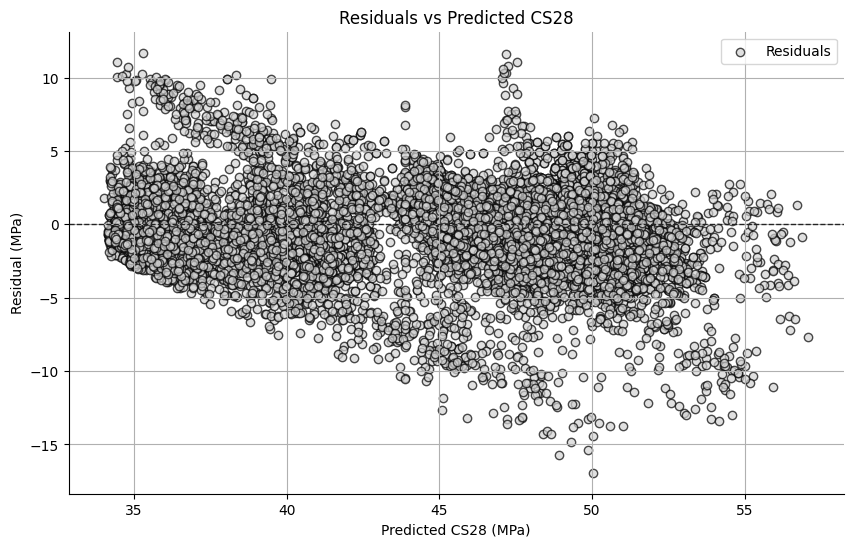

<IPython.core.display.Javascript object>

In [79]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="lightgray",
    alpha=0.7,
    edgecolor="black",
    label="Residuals"
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_btiss_top_one_pre_train_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


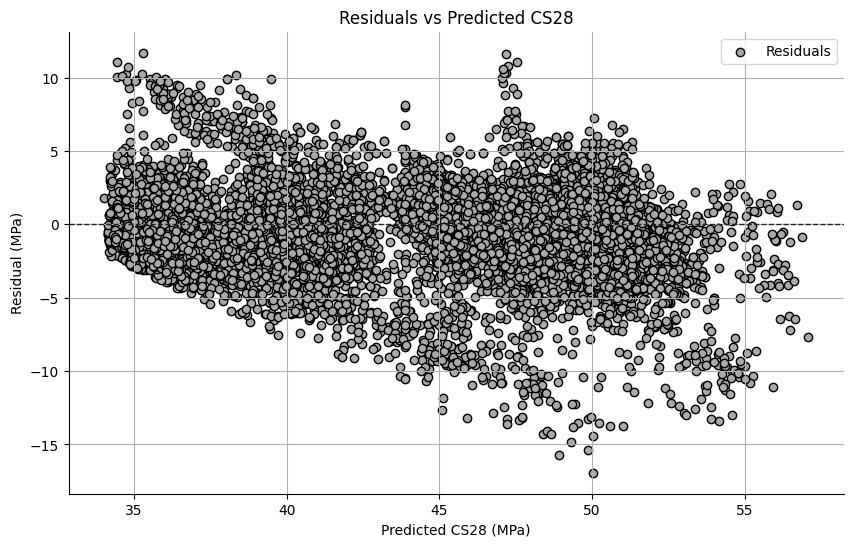

<IPython.core.display.Javascript object>

In [80]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="darkgray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_btiss_top_one_pre_train_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

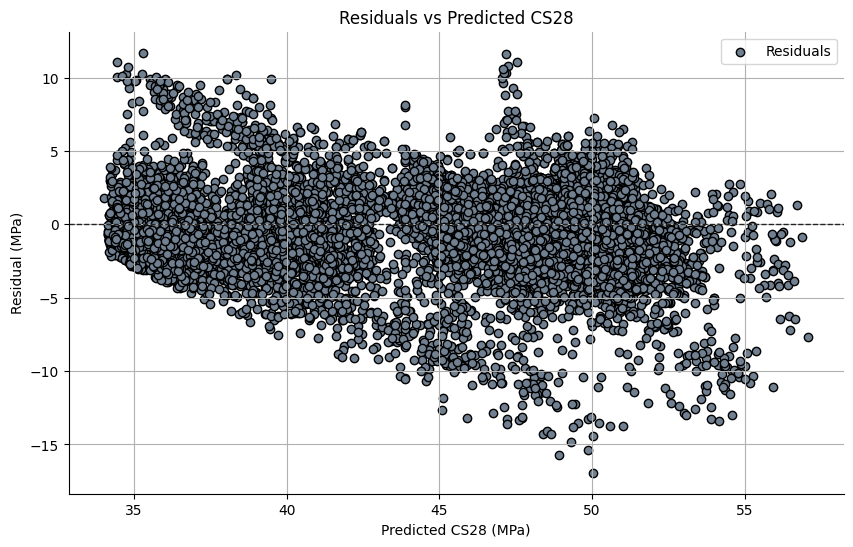

<IPython.core.display.Javascript object>

In [81]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="slategray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_btiss_top_one_pre_train_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

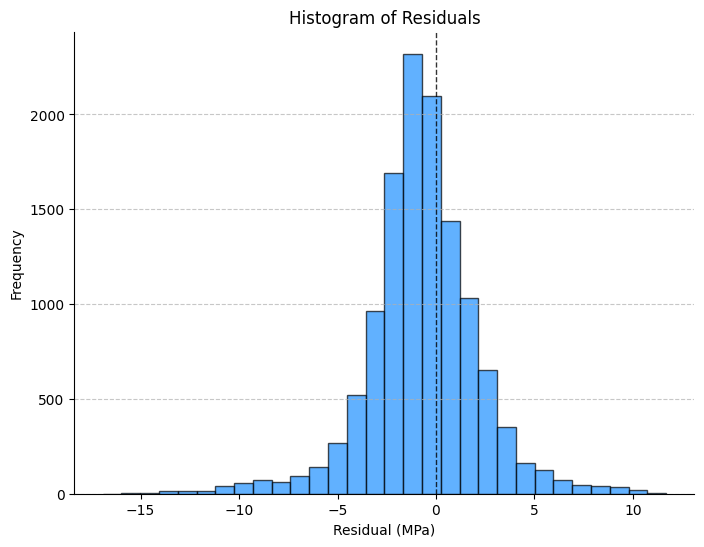

<IPython.core.display.Javascript object>

In [82]:
plt.figure(figsize=(8, 6))

# Plot histogram of residuals
plt.hist(
    test_data["RESIDUAL"],
    bins=30,  # Number of bins for better granularity
    color="dodgerblue",
    edgecolor="black",
    alpha=0.7
)

# Add labels and title
plt.xlabel("Residual (MPa)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

# Add a vertical line at 0 for reference
plt.axvline(x=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Remove top and right spines for cleaner aesthetics
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the plot
plt.savefig(
    "ecics_global_cm_btiss_dominant_top_one_pre_train_residual_histogram.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


In [83]:
def permutation_importance_seq_distribution(model, X, y, metric, n_repeats=10):
    """
    Computes permutation importance for sequence models with 3D input,
    returning the distribution of importance scores across repetitions.
    """
    baseline_score = metric(y, model.predict(X))
    num_features = X.shape[2]  # Number of features
    importances = np.zeros(
        (num_features, n_repeats)
    )  # Store all scores for distribution
    set_seeds()  # Ensure reproducibility if necessary

    for i in range(num_features):
        for repeat in range(n_repeats):
            X_permuted = X.copy()
            # Shuffle feature i across samples, keeping time steps intact
            for t in range(X.shape[1]):
                feature_values = X_permuted[:, t, i]
                np.random.shuffle(feature_values)
                X_permuted[:, t, i] = feature_values
            # Compute metric with permuted data
            permuted_score = metric(y, model.predict(X_permuted, verbose=0))
            # Store the importance score for this repetition
            importances[i, repeat] = baseline_score - permuted_score

    return importances

<IPython.core.display.Javascript object>

In [84]:
# Compute permutation importance
feature_importances = []
# importances = permutation_importance_seq(model, x_test, y_test, r2_score, n_repeats=10)
importances = permutation_importance_seq_distribution(
    model, x_test, y_test, r2_score, n_repeats=10
)
feature_importances.append(importances)
# feature_importances = feature_importances[0].T
feature_importances = importances.T

<IPython.core.display.Javascript object>

In [85]:
import numpy as np
import pandas as pd
import seaborn as sns

# Average importances across folds
# mean_importances = np.mean(feature_importances.T, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(feature_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

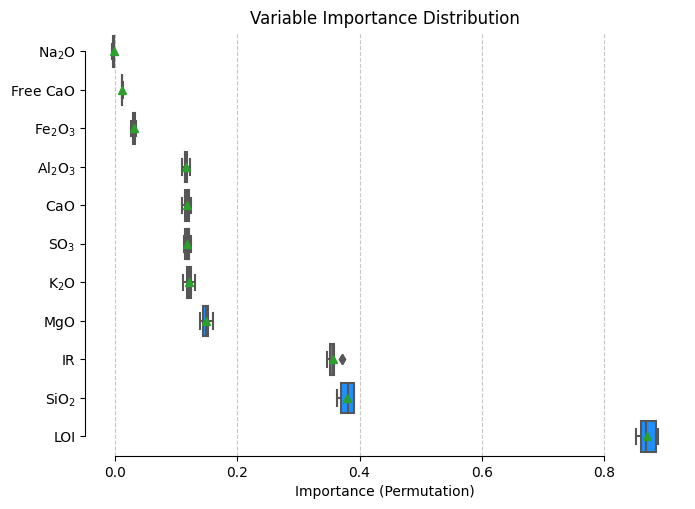

<IPython.core.display.Javascript object>

In [86]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="dodgerblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_global_cm_btiss_pre_train_transformer_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

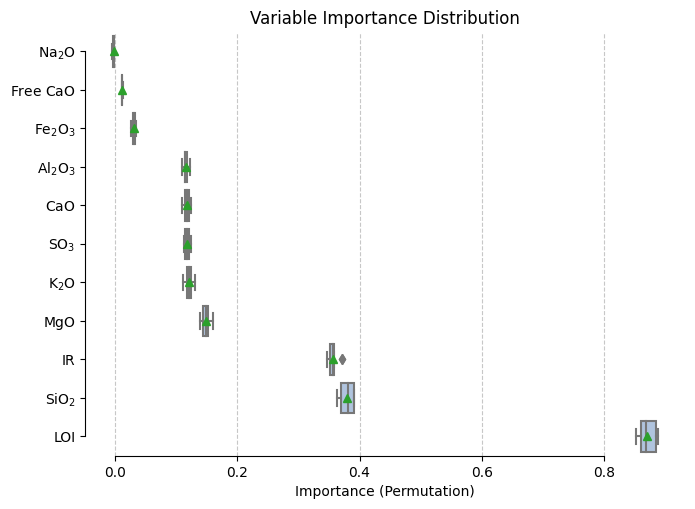

<IPython.core.display.Javascript object>

In [87]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_global_cm_btiss_pre_train_transformer_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

In [88]:
perm_importances_df_plot

$\mathrm{Na_2O}$  Free $\mathrm{CaO}$  $\mathrm{Fe_2O_3}$  \
0         -0.002345             0.012085            0.031198   
1         -0.000972             0.013262            0.033504   
2         -0.000953             0.011222            0.030619   
3         -0.003714             0.011414            0.028992   
4         -0.000725             0.011351            0.028283   
5         -0.001961             0.013114            0.033113   
6         -0.001926             0.011094            0.030249   
7         -0.001803             0.012146            0.033128   
8         -0.002903             0.011826            0.026730   
9         -0.001623             0.012751            0.034891   

   $\mathrm{Al_2O_3}$  $\mathrm{CaO}$  $\mathrm{SO_3}$  $\mathrm{K_2O}$  \
0            0.114741        0.112793         0.115276         0.129555   
1            0.114062        0.123494         0.113971         0.118141   
2            0.116449        0.116152         0.122376         0.120620   
3            0.119291        0.117593         0.117849         0.117791   
4            0.113583        0.117005         0.118751         0.124645   
5            0.118478        0.114139         0.117502         0.131331   
6            0.115052        0.122550         0.114487         0.121103   
7            0.122473        0.117937         0.124712         0.110766   
8            0.109890        0.110658         0.114068         0.123443   
9            0.114520        0.123851         0.121947         0.119327   

   $\mathrm{MgO}$        IR  $\mathrm{SiO_2}$       LOI  
0        0.142898  0.357791          0.368919  0.885193  
1        0.149975  0.357516          0.384216  0.881923  
2        0.144420  0.347405          0.390743  0.854010  
3        0.144330  0.350985          0.370099  0.884259  
4        0.160771  0.356370          0.388328  0.858698  
5        0.140051  0.372001          0.390772  0.887595  
6        0.149119  0.370882          0.363896  0.865669  
7        0.151248  0.356139          0.378086  0.851828  
8        0.153749  0.355665          0.390924  0.867783  
9        0.156540  0.349452          0.369392  0.867121

<IPython.core.display.Javascript object>

In [89]:
perm_importances_df_plot.describe()

$\mathrm{Na_2O}$  Free $\mathrm{CaO}$  $\mathrm{Fe_2O_3}$  \
count         10.000000            10.000000           10.000000   
mean          -0.001892             0.012027            0.031071   
std            0.000926             0.000792            0.002598   
min           -0.003714             0.011094            0.026730   
25%           -0.002249             0.011367            0.029306   
50%           -0.001865             0.011955            0.030908   
75%           -0.001135             0.012600            0.033125   
max           -0.000725             0.013262            0.034891   

       $\mathrm{Al_2O_3}$  $\mathrm{CaO}$  $\mathrm{SO_3}$  $\mathrm{K_2O}$  \
count           10.000000       10.000000        10.000000        10.000000   
mean             0.115854        0.117617         0.118094         0.121672   
std              0.003504        0.004523         0.003829         0.005970   
min              0.109890        0.110658         0.113971         0.110766   
25%              0.114177        0.114642         0.114684         0.118438   
50%              0.114896        0.117299         0.117676         0.120861   
75%              0.117971        0.121396         0.121148         0.124345   
max              0.122473        0.123851         0.124712         0.131331   

       $\mathrm{MgO}$         IR  $\mathrm{SiO_2}$        LOI  
count       10.000000  10.000000         10.000000  10.000000  
mean         0.149310   0.357421          0.379538   0.870408  
std          0.006524   0.008199          0.010709   0.013457  
min          0.140051   0.347405          0.363896   0.851828  
25%          0.144352   0.352155          0.369569   0.860441  
50%          0.149547   0.356255          0.381151   0.867452  
75%          0.153124   0.357722          0.390139   0.883675  
max          0.160771   0.372001          0.390924   0.887595

<IPython.core.display.Javascript object>